In [97]:
## ECE 397 - Individual Study in ECE Problems
## Professor: Thomas Moon
## Student: Jihyun Seo

## This program uses an SDR device to transmit and receive a message wirelessly.
## The message ("Hello world") is converted to a bitstream using ASCII encoding, then
## processed through essential wireless communication stages.

## Communication System Overview:
## - Modulation: The bitstream is modulated using 4-QAM for simplicity.
## - Processing: The system applies pulse shaping, matched filtering, symbol timing recovery, 
##               frame synchronization, channel equalization, and demodulation.

## Objective:
## The goal is to successfully transmit "Hello world" and accurately recover it at the receiver 
## by performing these core wireless communication functions.


In [98]:
import numpy as np
import matplotlib.pyplot as plt 
import adi
from scipy import signal
from PIL import Image

In [99]:
############ Channel Estimation: Lab 7 ############
# Channel Estimation: 

def estimate_h(rx_preamble, tx_preamble, L):
    """
    Estimate the channel response h.

    Parameters
    ----------
    rx_preamble : 1-D ndarray of complex floats
        The received preamble.

    tx_preamble : 1-D ndarray of floats
        The original preamble sent from Tx.

    L : int
        The length of the channel.

    Returns
    -------
    hhat : 1-D ndarray of complex floats
        The estimated channel (in time-domain).
    """
    N = tx_preamble.size
    A = np.zeros((N - L + 1, L), dtype=complex)
    
    # Build the matrix A using delayed versions of the Tx preamble
    for k in range(N - L + 1):
        A[k, :] = np.flip(tx_preamble[k:k+L])
    
    # Received preamble symbols for estimation
    y = rx_preamble[L-1:N]
    
    # Least Squares solution to estimate the channel
    hhat = np.linalg.lstsq(A, y, rcond=None)[0]
    
    return hhat
############ YOUR CODE ENDS HERE ############

In [100]:
def generate_bpsk_frame(sps=8, fs=1e6, carrier_freq=2.4e9):
    """
    Generates a BPSK frame with Barker-13 preamble and guard band.

    Parameters:
    sps (int): Samples per symbol (upsampling factor).
    fs (float): Sampling rate in Hz.
    carrier_freq (float): Carrier frequency in Hz.

    Returns:
    tuple: Barker-13 preamble, guard band, and parameters.
    """
    
    # Step 1: Barker-13 Preamble (1s and -1s)
    barker_13 = np.array([1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1])

    # Step 2: Generate a guard band (same length as the preamble, filled with zeros)
    guard_band = np.zeros(len(barker_13))

    return barker_13, guard_band, sps, fs, carrier_freq

# Example usage
barker_13, guard_band, sps, fs, carrier_freq = generate_bpsk_frame()

In [101]:
############# Define RRC Filter ###################

def rrcosfilter(N, alpha, Ts, Fs):
    """
    Generates a root raised cosine (RRC) filter (FIR) impulse response.

    Parameters
    ----------
    N : int
        Length of the filter in samples.

    alpha : float
        Roll off factor (Valid values are [0, 1]).

    Ts : float
        Symbol period in seconds.

    Fs : float
        Sampling Rate in Hz.

    Returns
    ---------

    time_idx : 1-D ndarray of floats
        Array containing the time indices, in seconds, for
        the impulse response.

    h_rrc : 1-D ndarray of floats
        Impulse response of the root raised cosine filter.
    """

    T_delta = 1/float(Fs)
    time_idx = ((np.arange(N)-N/2))*T_delta
    sample_num = np.arange(N)
    h_rrc = np.zeros(N, dtype=float)

    for x in sample_num:
        t = (x-N/2)*T_delta
        if t == 0.0:
            h_rrc[x] = 1.0 - alpha + (4*alpha/np.pi)
        elif alpha != 0 and t == Ts/(4*alpha):
            h_rrc[x] = (alpha/np.sqrt(2))*(((1+2/np.pi)* \
                    (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        elif alpha != 0 and t == -Ts/(4*alpha):
            h_rrc[x] = (alpha/np.sqrt(2))*(((1+2/np.pi)* \
                    (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        else:
            h_rrc[x] = (np.sin(np.pi*t*(1-alpha)/Ts) +  \
                    4*alpha*(t/Ts)*np.cos(np.pi*t*(1+alpha)/Ts))/ \
                    (np.pi*t*(1-(4*alpha*t/Ts)*(4*alpha*t/Ts))/Ts)

    return time_idx, h_rrc




In [102]:
######################### Set up PlutoSDR Tx and Rx ######################## 
# Transmit settings
sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(fs)

# Config Tx
# filter cutoff, just set it to the same as sample rate, valid range is 200 kHz to 20 MHz
sdr.tx_rf_bandwidth = int(fs) 
# set carrier frequency, valid range is 380 MHz to 3.8GHz
sdr.tx_lo = int(carrier_freq)
# set tx power, valid range is -90 to 0 dB
sdr.tx_hardwaregain_chan0 = -5

# Config Rx
sdr.rx_lo = int(carrier_freq)
sdr.rx_rf_bandwidth = int(fs)
sdr.rx_buffer_size = 128
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0 = 40.0

print("carrier_freq: " ,carrier_freq)
print("sampling_frequency : ", fs)

carrier_freq:  2400000000.0
sampling_frequency :  1000000.0


In [103]:
#################### Step 1: Import or define image and convert it to bitstream ##################

# Load the PNG file
image_path = r"C:\Users\Administrator\Desktop\ECE 397\Python Project\high_res_binary_animal.2.png"  # Replace with your file path
image = Image.open(image_path).convert("L")  # Convert to grayscale

# Convert to binary (0 or 1)
binary_image = (np.array(image) > 128).astype(np.uint8)  # Threshold at 128

# Print the binary image for verification
#print("Binary Image Array:")
#print(binary_image)
#print(binary_image.shape)

bitstream = binary_image.flatten()
print("length of the bitstream : ",len(bitstream))

bits = bitstream

length of the bitstream :  10000


In [104]:
############# Step 2: Define modulation parameters ##################
M = 2 # BPSK or M-QAM  chose BPSK for the convenience
bits_per_symbol = int(np.log2(M))
num_data_symbols = len(bits) // bits_per_symbol  # Number of symbols that can be formed from bits
bits = bits[:num_data_symbols * bits_per_symbol]  # Truncate to fit into complete symbols if needed

print("bits_per_1_symbol:", bits_per_symbol)
print("num_data_symbols: ",num_data_symbols)
print("length of the bits: ",len(bits))

bits_per_1_symbol: 1
num_data_symbols:  10000
length of the bits:  10000


In [105]:
############# Step 2: Define modulation parameters ##################

############# M-QAM Decision ##################### 


# Define modulation mappings
if M == 2:  # BPSK
    # BPSK with Gray coding: 0 -> +1, 1 -> -1
    gray_mapping = {
        (0,): -1,
        (1,): 1
    }
    normalization_factor = 1

elif M == 4:  # 4-QAM
    # 4-QAM with Gray coding
    gray_mapping = {
        (0, 0): -1 - 1j,
        (0, 1): 1 - 1j,
        (1, 1):  1 + 1j,
        (1, 0):  -1 + 1j
    }
    normalization_factor = np.sqrt(2)

elif M == 16:  # 16-QAM
    # 16-QAM with Gray coding
    gray_mapping = {
        (1, 0, 0, 0): -3 + 3j, (1, 0, 0, 1): -1 + 3j,
        (1, 0, 1, 1): 1 + 3j, (1, 0, 1, 0): 3 + 3j,
        
        (1, 1, 0, 0): -3 + 1j, (1, 1, 0, 1): -1 + 1j,
        (1, 1, 1, 1): 1 + 1j, (1, 1, 1, 0): 3 + 1j,
        
        (0, 1, 0, 0):  -3 - 1j, (0, 1, 0, 1):  -1 - 1j,
        (0, 1, 1, 1):  1 -1j, (0, 1, 1, 0):  3 - 1j,
        
        (0, 0, 0, 0):  -3 - 3j, (0, 0, 0, 1):  -1 - 3j,
        (0, 0, 1, 1):  1 - 3j, (0, 0, 1, 0):  3 - 3j
    }
    normalization_factor = np.sqrt(10)   
#######################################################################


In [106]:

################# Map bits to symbols #################

mqam_symbols = []
symbol_labels = []  # To store labels in correct order

for i in range(0, len(bits), bits_per_symbol):
    # Adjust the order of bits if necessary to align with MSB-LSB orientation
    bit_tuple = tuple(bits[i:i + bits_per_symbol])  # Keep the original order without reversing
    symbol = gray_mapping[bit_tuple]
    
    mqam_symbols.append(symbol / normalization_factor)  # Normalize the symbol
    symbol_labels.append("".join(map(str, bit_tuple)))  # Save the bit label in correct order

# Convert to NumPy array
mqam_symbols = np.array(mqam_symbols)


# Print mqam_symbols and corresponding labels
#print("Symbols:", mqam_symbols)

#print("\nLabels:", symbol_labels)

#print("\noriginal bits: ",bits)


############ YOUR CODE STOPS HERE ############


In [107]:
# Parameters
symbols_per_packet = 100  # Adjust packet size based on symbols, not bits
num_packets = len(mqam_symbols) // symbols_per_packet
received_bits = []



In [108]:
#print(bits)

1-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


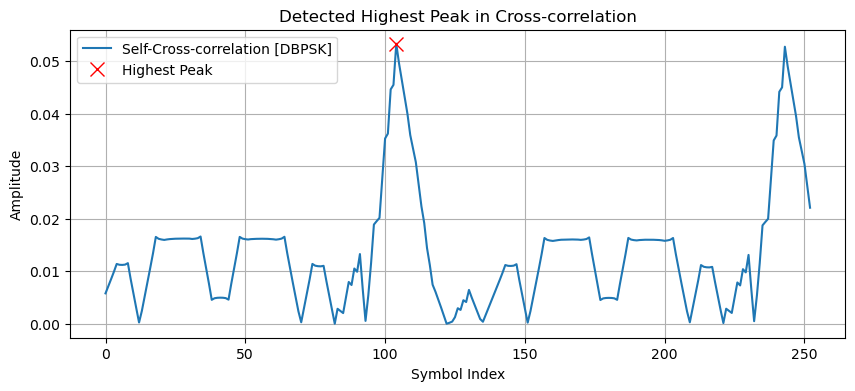

Peak index of highest peak: 104
Value of highest peak: 0.053306645485465085
Estimated CFO (Hz): -38.481890738783854
Angle_A :  0.0031432550562714196
length of demod_bits:  100
1-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
2-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


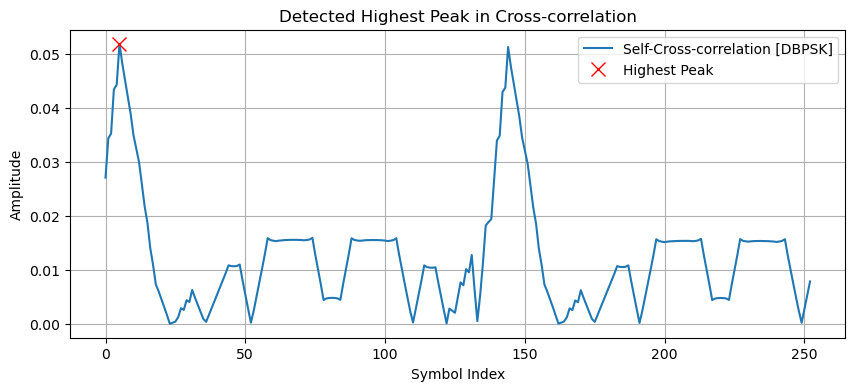

Peak index of highest peak: 5
Value of highest peak: 0.051944777727922095
Estimated CFO (Hz): -17.4081316104451
Angle_A :  0.001421920717882563
length of demod_bits:  100
2-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
3-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


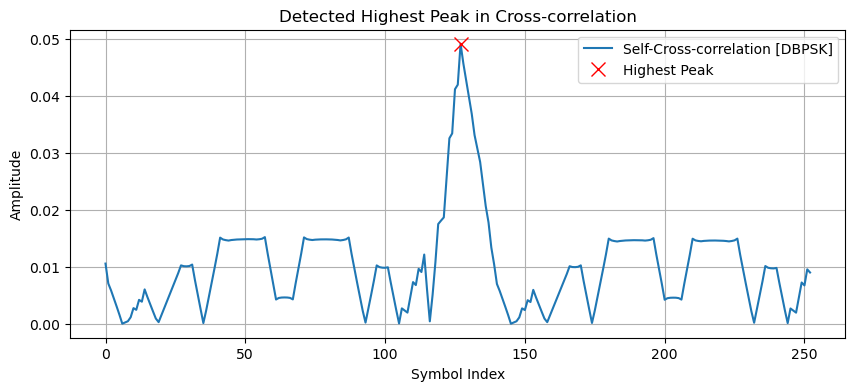

Peak index of highest peak: 127
Value of highest peak: 0.04916196811942073
Estimated CFO (Hz): -8.697189899908345
Angle_A :  0.0007103987253071125
length of demod_bits:  100
3-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
4-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


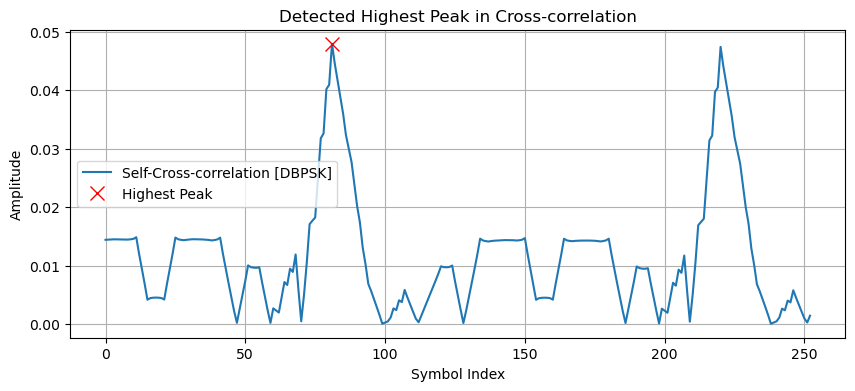

Peak index of highest peak: 81
Value of highest peak: 0.04795137252274393
Estimated CFO (Hz): 20.21609011498872
Angle_A :  -0.0016512787249285028
length of demod_bits:  100
4-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
5-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


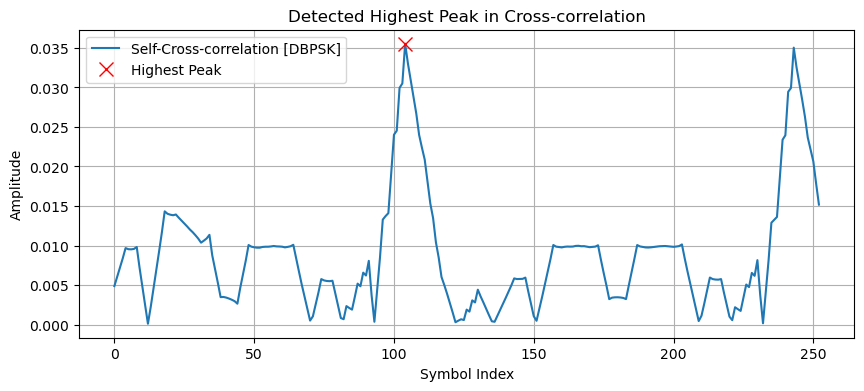

Peak index of highest peak: 104
Value of highest peak: 0.0355299949097784
Estimated CFO (Hz): -17.175050051741938
Angle_A :  0.0014028822877573263
length of demod_bits:  100
5-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
6-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


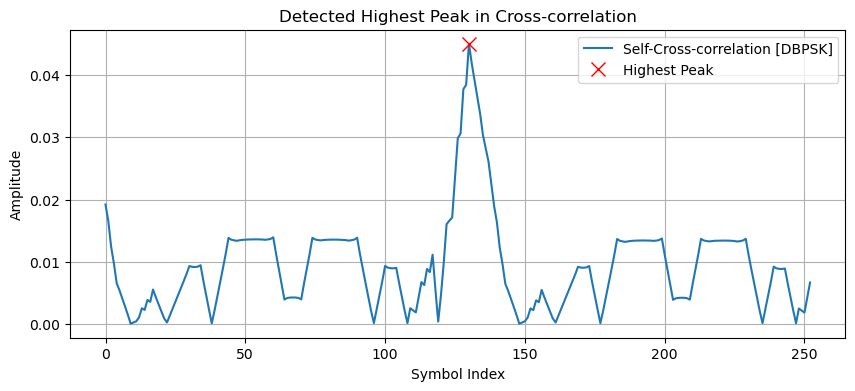

Peak index of highest peak: 130
Value of highest peak: 0.04504929259003166
Estimated CFO (Hz): 3.144491182652688
Angle_A :  -0.0002568464703661887
length of demod_bits:  100
6-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
7-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


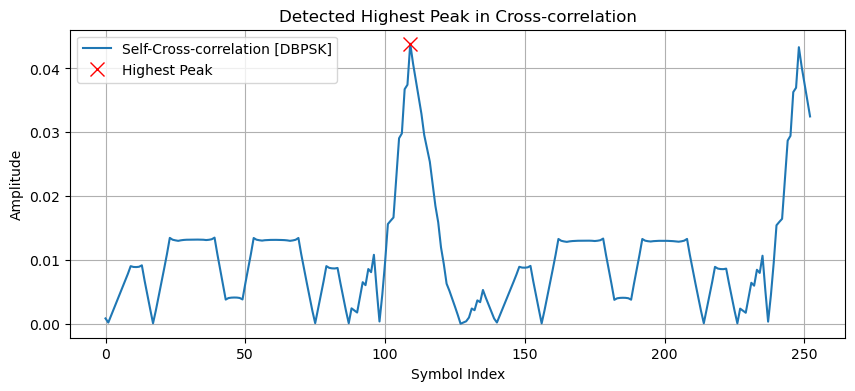

Peak index of highest peak: 109
Value of highest peak: 0.04387721113486619
Estimated CFO (Hz): -5.477829553069887
Angle_A :  0.0004474368361200768
length of demod_bits:  100
7-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
8-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


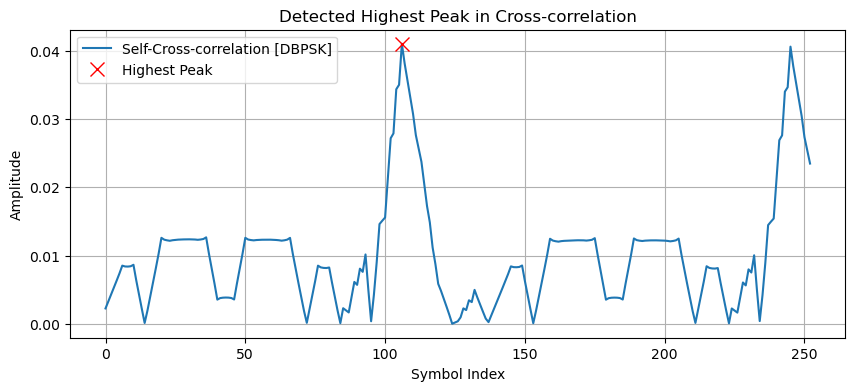

Peak index of highest peak: 106
Value of highest peak: 0.04102550711889899
Estimated CFO (Hz): -16.258442711251984
Angle_A :  0.0013280125086924735
length of demod_bits:  100
8-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
9-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


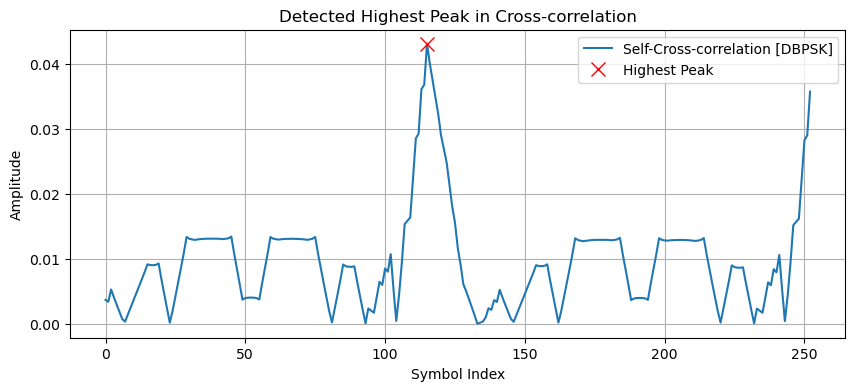

Peak index of highest peak: 115
Value of highest peak: 0.043172467851156915
Estimated CFO (Hz): -12.555363422970963
Angle_A :  0.001025539774811645
length of demod_bits:  100
9-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
10-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


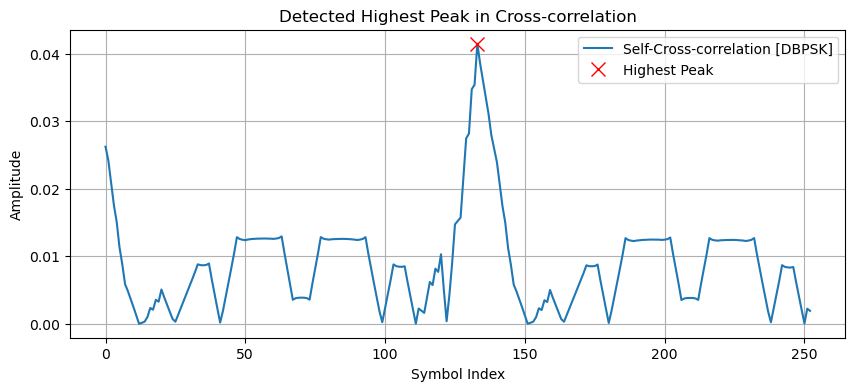

Peak index of highest peak: 133
Value of highest peak: 0.04150440222619763
Estimated CFO (Hz): -1.9241055192970495
Angle_A :  0.0001571636498680348
length of demod_bits:  100
10-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
11-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


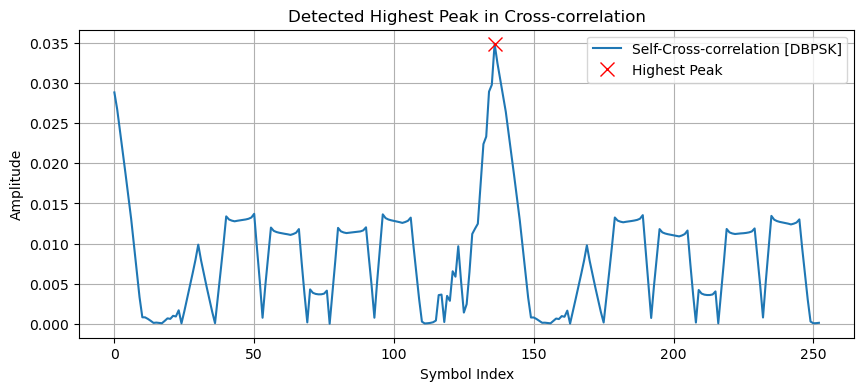

Peak index of highest peak: 136
Value of highest peak: 0.034900925342509645
Estimated CFO (Hz): -13.633559446805707
Angle_A :  0.0011136083452094778
length of demod_bits:  100
11-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
12-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


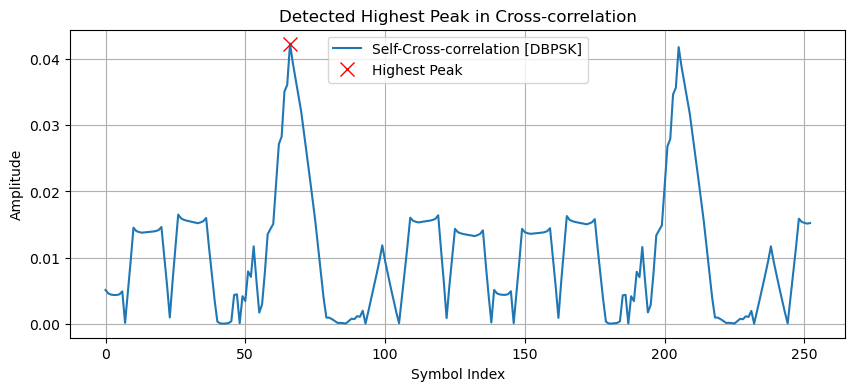

Peak index of highest peak: 66
Value of highest peak: 0.04229853008157083
Estimated CFO (Hz): -26.802675963689623
Angle_A :  0.002189280337505951
length of demod_bits:  100
12-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
13-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


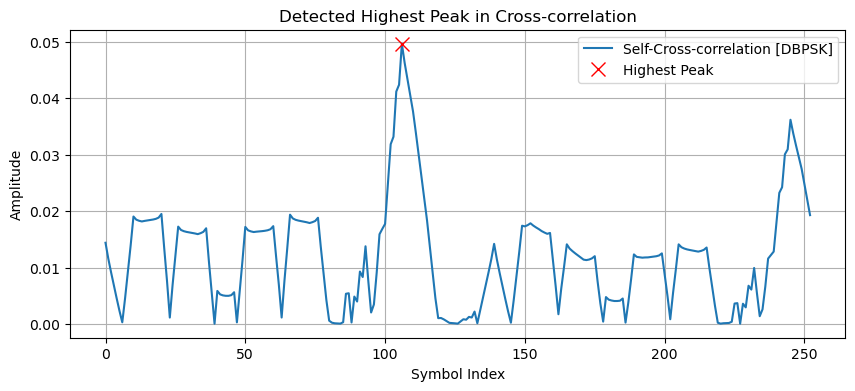

Peak index of highest peak: 106
Value of highest peak: 0.04967426204074333
Estimated CFO (Hz): -17.855851959139688
Angle_A :  0.0014584911467989243
length of demod_bits:  100
13-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
14-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


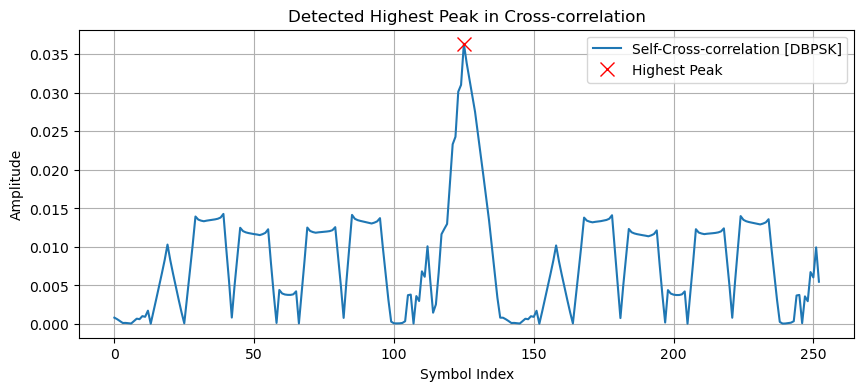

Peak index of highest peak: 125
Value of highest peak: 0.03636626751502407
Estimated CFO (Hz): -28.039579934815315
Angle_A :  0.0022903123966569487
length of demod_bits:  100
14-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
15-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


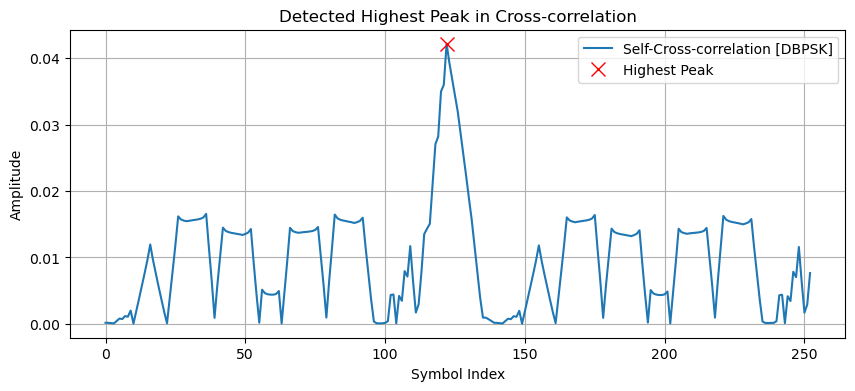

Peak index of highest peak: 122
Value of highest peak: 0.042156068830616046
Estimated CFO (Hz): -24.446047454230225
Angle_A :  0.0019967876003794457
length of demod_bits:  100
15-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
16-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


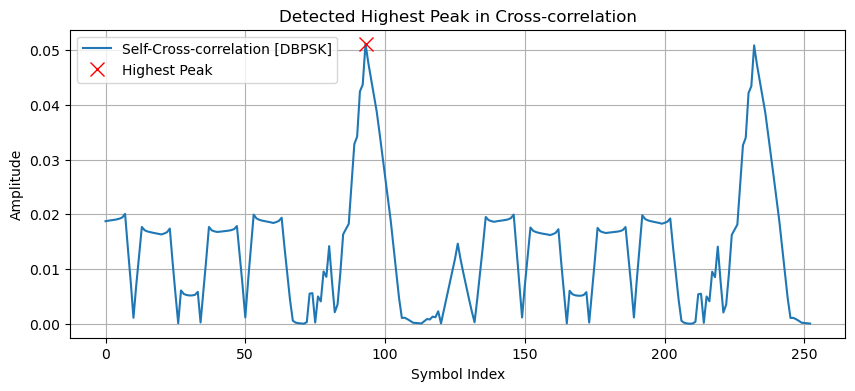

Peak index of highest peak: 93
Value of highest peak: 0.05115697903826898
Estimated CFO (Hz): 20.36326084957593
Angle_A :  -0.0016632998378921702
length of demod_bits:  100
16-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
17-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


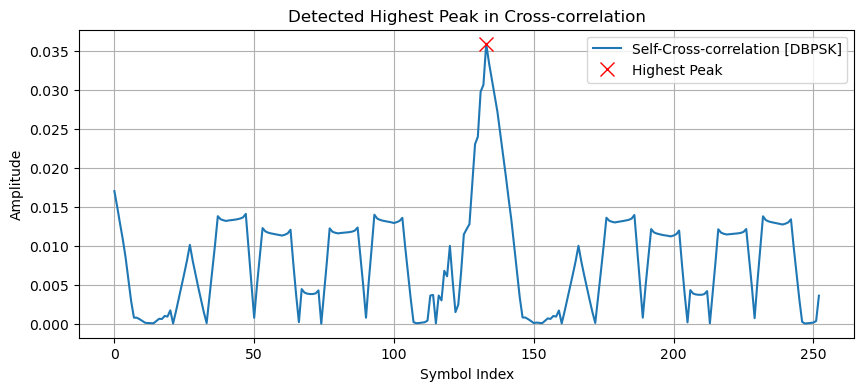

Peak index of highest peak: 133
Value of highest peak: 0.03586847429655709
Estimated CFO (Hz): 50.2964793895231
Angle_A :  -0.004108287303940462
length of demod_bits:  100
17-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
18-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


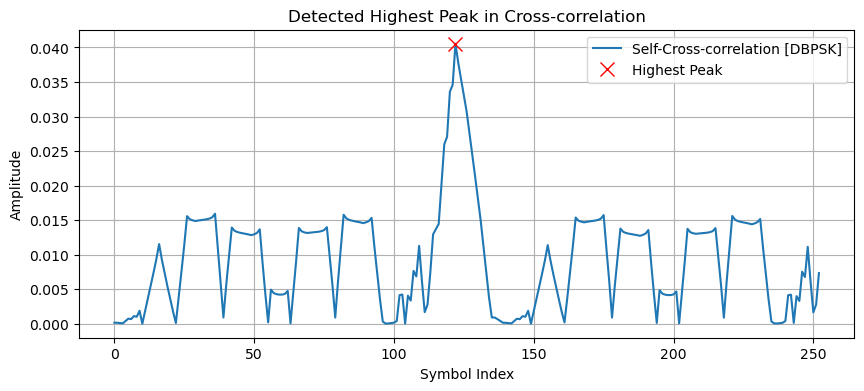

Peak index of highest peak: 122
Value of highest peak: 0.040537106764055336
Estimated CFO (Hz): -31.377444475310945
Angle_A :  0.002562953875353521
length of demod_bits:  100
18-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
19-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


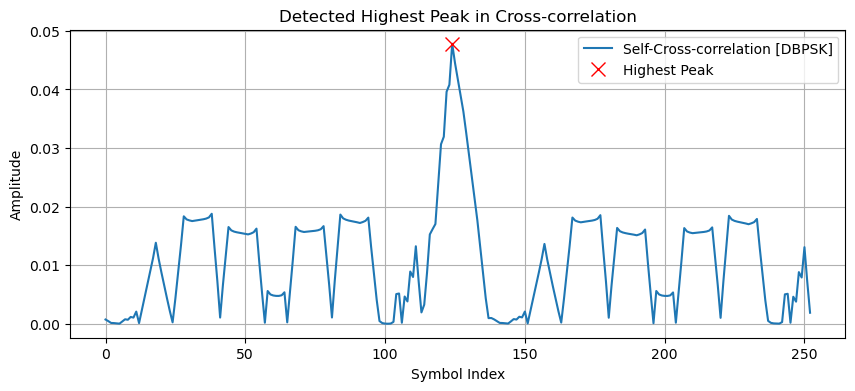

Peak index of highest peak: 124
Value of highest peak: 0.04779263405094652
Estimated CFO (Hz): -13.251138081601622
Angle_A :  0.0010823716292704536
length of demod_bits:  100
19-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
20-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


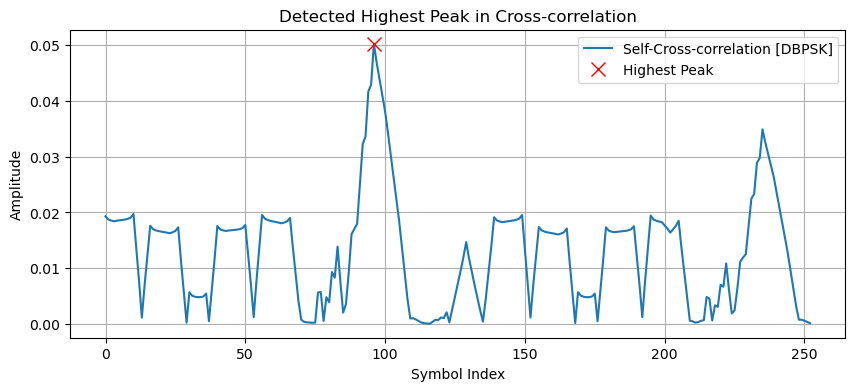

Peak index of highest peak: 96
Value of highest peak: 0.050274993707687926
Estimated CFO (Hz): 20.46830696727998
Angle_A :  -0.0016718801527955166
length of demod_bits:  100
20-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
21-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


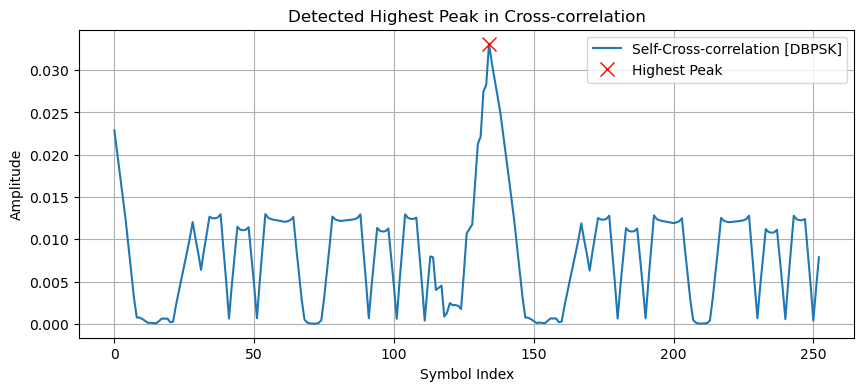

Peak index of highest peak: 134
Value of highest peak: 0.03311813082057641
Estimated CFO (Hz): -69.32998774114476
Angle_A :  0.005662971084187321
length of demod_bits:  100
21-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
22-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


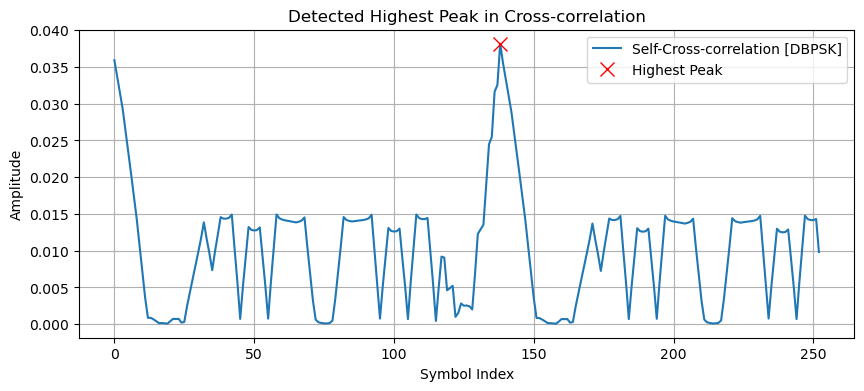

Peak index of highest peak: 138
Value of highest peak: 0.03815796737957208
Estimated CFO (Hz): -23.188680868415695
Angle_A :  0.0018940841260289762
length of demod_bits:  100
22-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
23-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


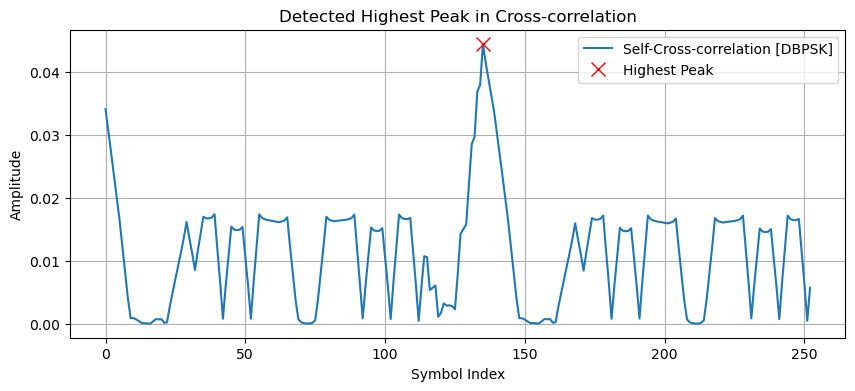

Peak index of highest peak: 135
Value of highest peak: 0.04453675684668198
Estimated CFO (Hz): -36.32798867837847
Angle_A :  0.0029673213011438613
length of demod_bits:  100
23-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
24-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


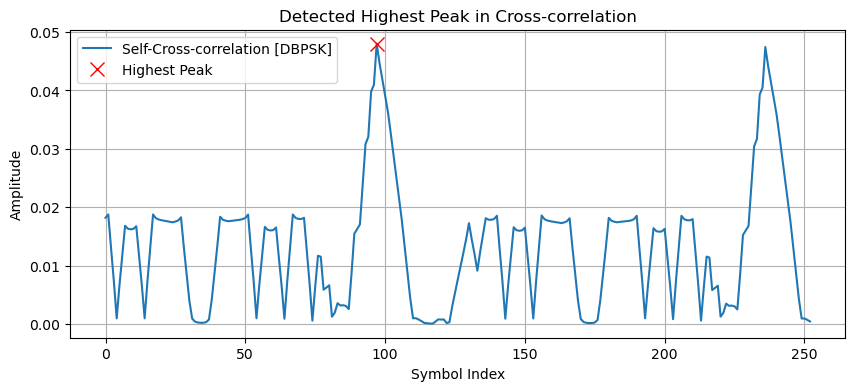

Peak index of highest peak: 97
Value of highest peak: 0.048001396744313134
Estimated CFO (Hz): 23.542335383160253
Angle_A :  -0.0019229711250901658
length of demod_bits:  100
24-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
25-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


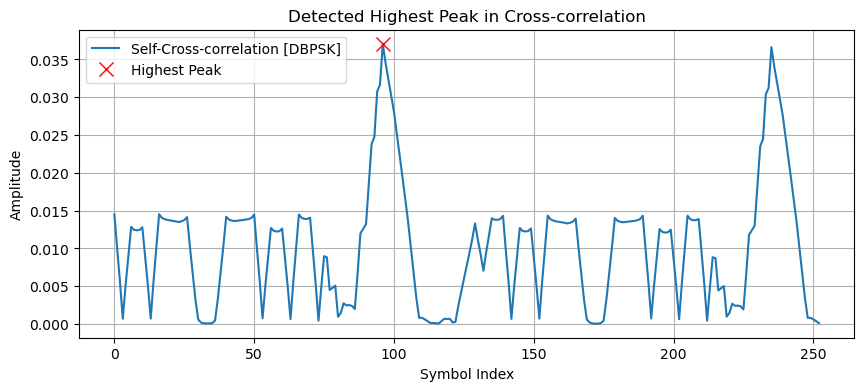

Peak index of highest peak: 96
Value of highest peak: 0.0370864704254298
Estimated CFO (Hz): -31.807853996785532
Angle_A :  0.0025981103315117124
length of demod_bits:  100
25-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
26-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


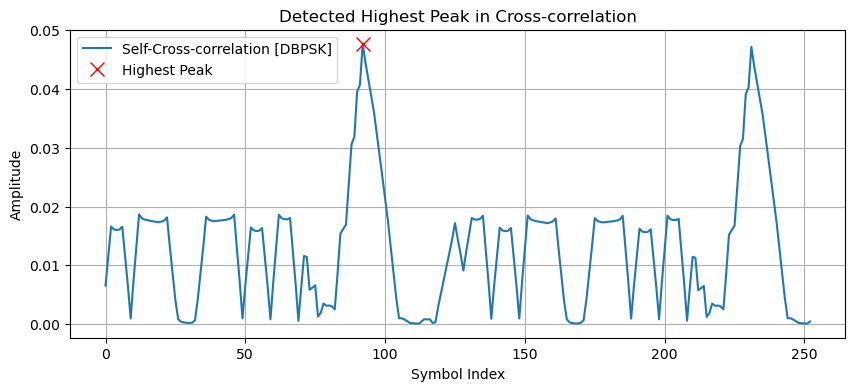

Peak index of highest peak: 92
Value of highest peak: 0.047709874177605305
Estimated CFO (Hz): -71.73190499324848
Angle_A :  0.005859163069624551
length of demod_bits:  100
26-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
27-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


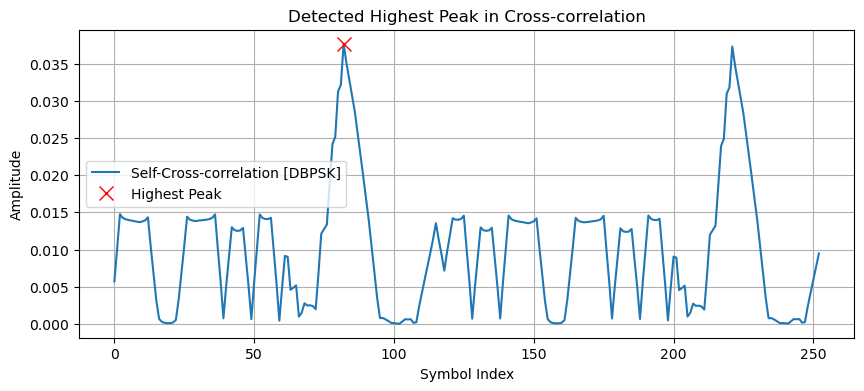

Peak index of highest peak: 82
Value of highest peak: 0.03765740794237812
Estimated CFO (Hz): -15.851117501159926
Angle_A :  0.0012947416116136483
length of demod_bits:  100
27-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
28-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


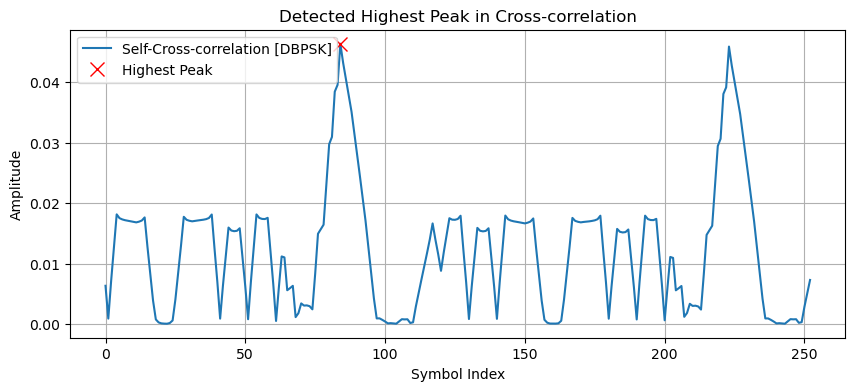

Peak index of highest peak: 84
Value of highest peak: 0.04634886757920639
Estimated CFO (Hz): 10.300576651638904
Angle_A :  -0.0008413656143497106
length of demod_bits:  100
28-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
29-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


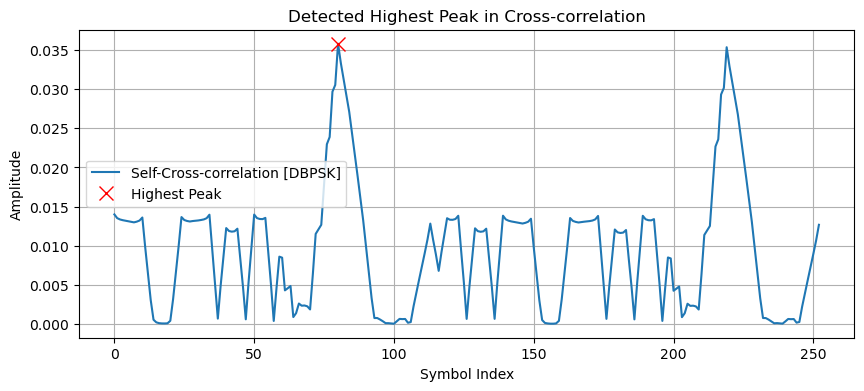

Peak index of highest peak: 80
Value of highest peak: 0.035786170687649395
Estimated CFO (Hz): -20.936620333163226
Angle_A :  0.0017101326483712712
length of demod_bits:  100
29-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
30-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


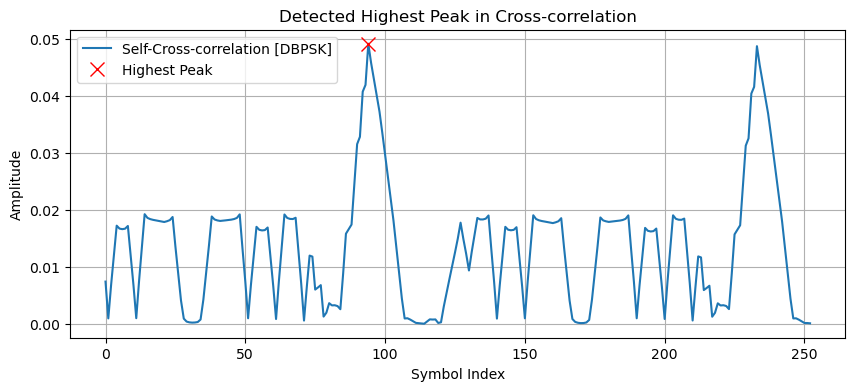

Peak index of highest peak: 94
Value of highest peak: 0.0492327760265002
Estimated CFO (Hz): -49.42175683708093
Angle_A :  0.004036838733378739
length of demod_bits:  100
30-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
31-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


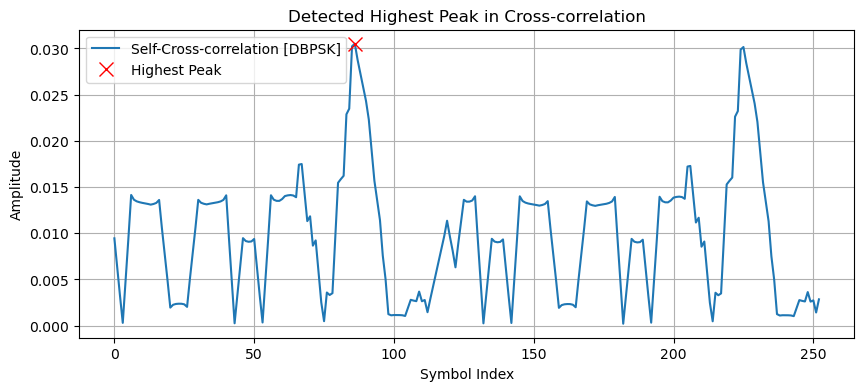

Peak index of highest peak: 86
Value of highest peak: 0.030508197237703445
Estimated CFO (Hz): 32.48931426610274
Angle_A :  -0.002653772966482519
length of demod_bits:  100
31-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
32-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


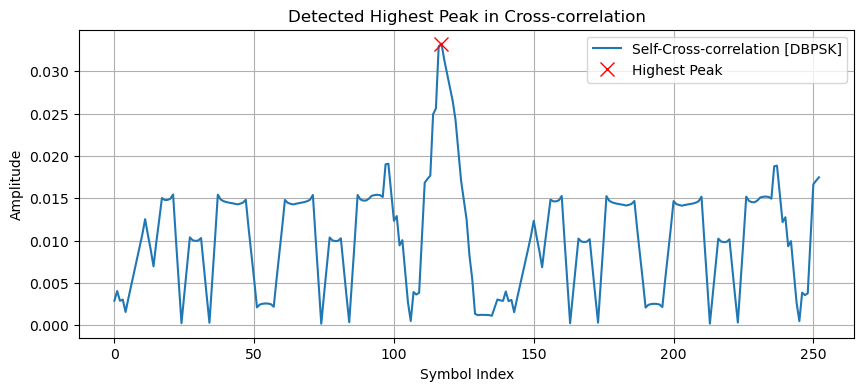

Peak index of highest peak: 117
Value of highest peak: 0.03325717367523425
Estimated CFO (Hz): 23.595639363196195
Angle_A :  -0.001927325069284454
length of demod_bits:  100
32-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
33-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


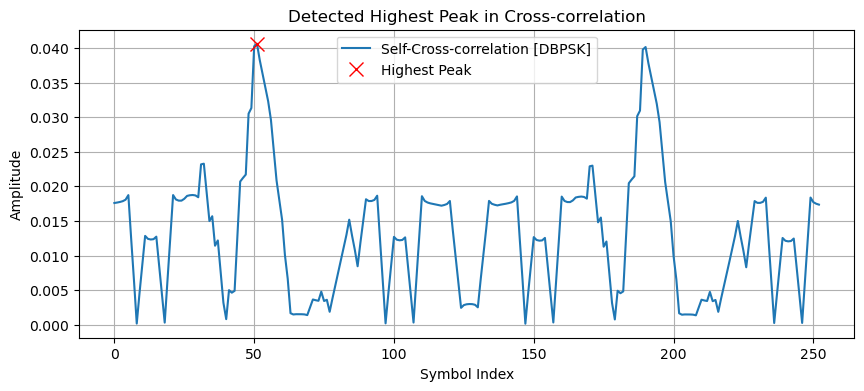

Peak index of highest peak: 51
Value of highest peak: 0.040604819741575385
Estimated CFO (Hz): -13.166220212926827
Angle_A :  0.0010754354181083854
length of demod_bits:  100
33-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
34-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


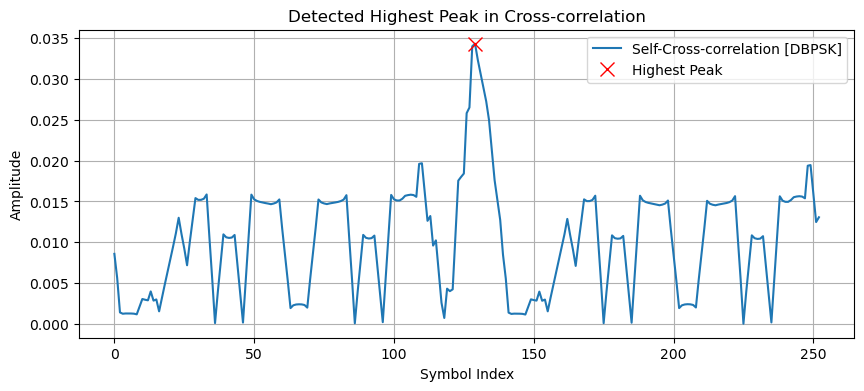

Peak index of highest peak: 129
Value of highest peak: 0.034272343787928705
Estimated CFO (Hz): -55.704953710225624
Angle_A :  0.004550059106959712
length of demod_bits:  100
34-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
35-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


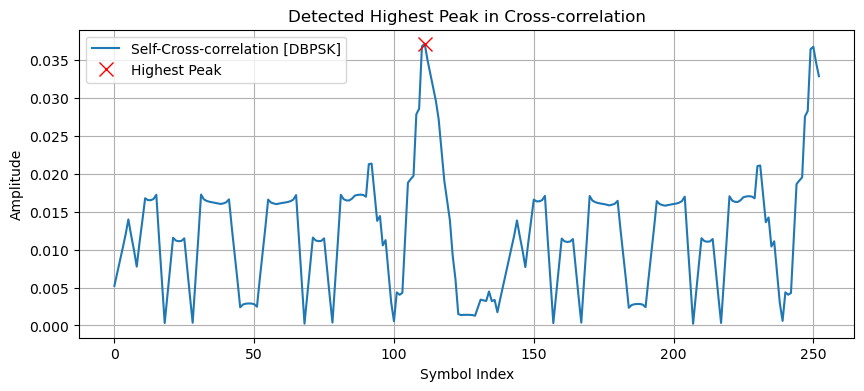

Peak index of highest peak: 111
Value of highest peak: 0.03710048529935872
Estimated CFO (Hz): 40.94185894631431
Angle_A :  -0.0033441887255413155
length of demod_bits:  100
35-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
36-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


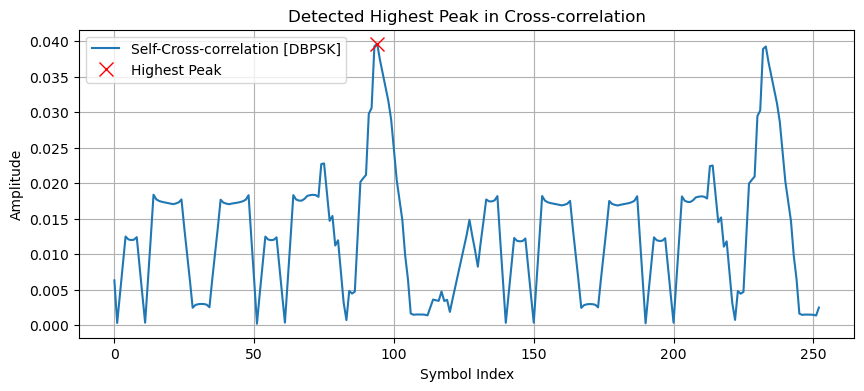

Peak index of highest peak: 94
Value of highest peak: 0.03964882826215869
Estimated CFO (Hz): -29.210438118294917
Angle_A :  0.002385949742814939
length of demod_bits:  100
36-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
37-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


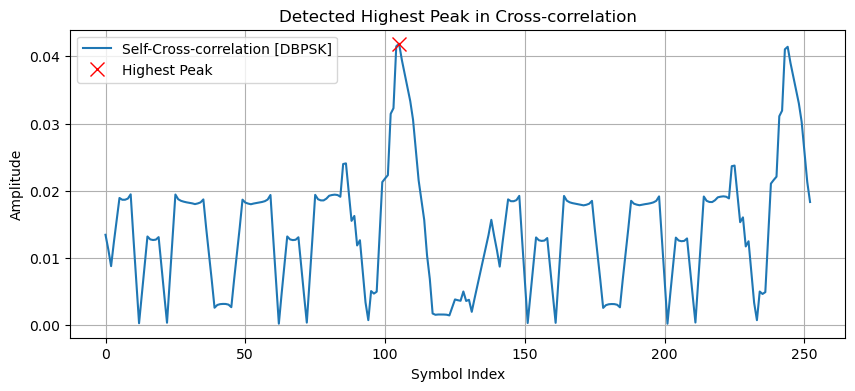

Peak index of highest peak: 105
Value of highest peak: 0.041880506649282945
Estimated CFO (Hz): 15.40489498841854
Angle_A :  -0.0012582935280483856
length of demod_bits:  100
37-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
38-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


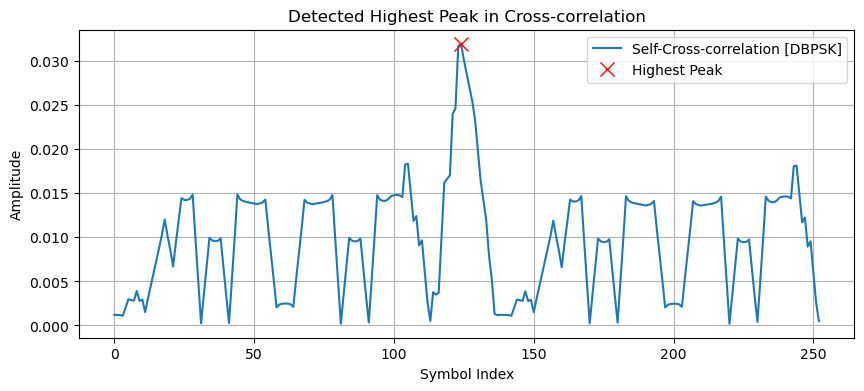

Peak index of highest peak: 124
Value of highest peak: 0.03196134074953676
Estimated CFO (Hz): -23.701826526649988
Angle_A :  0.0019359985864123655
length of demod_bits:  100
38-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
39-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


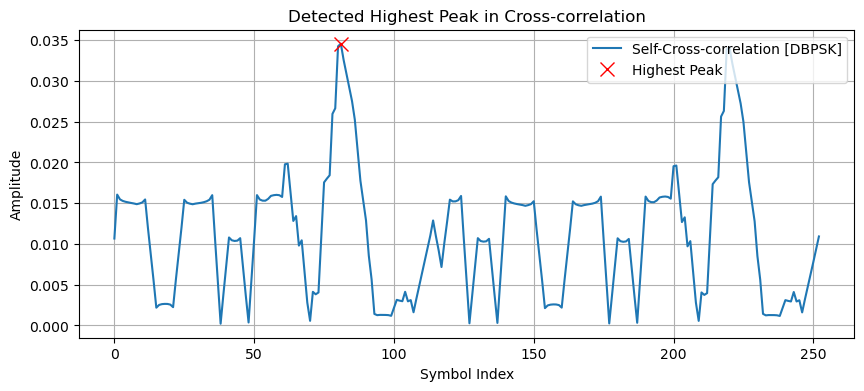

Peak index of highest peak: 81
Value of highest peak: 0.03457201164684382
Estimated CFO (Hz): 23.918518946237942
Angle_A :  -0.0019536983285624843
length of demod_bits:  100
39-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
40-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


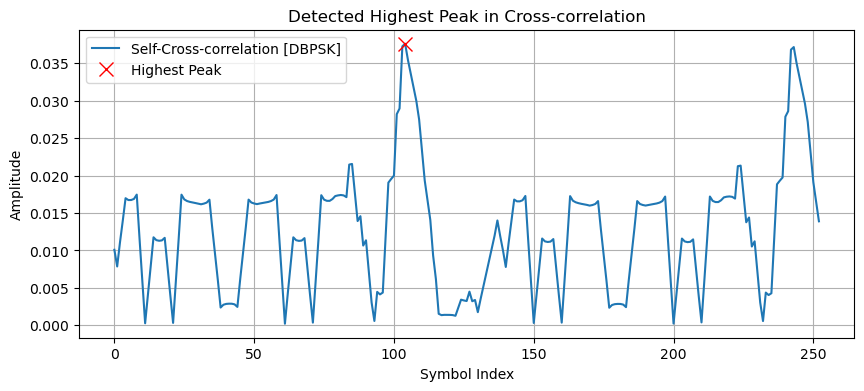

Peak index of highest peak: 104
Value of highest peak: 0.037598072240531154
Estimated CFO (Hz): -10.435693091764314
Angle_A :  0.0008524021155573176
length of demod_bits:  100
40-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
41-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


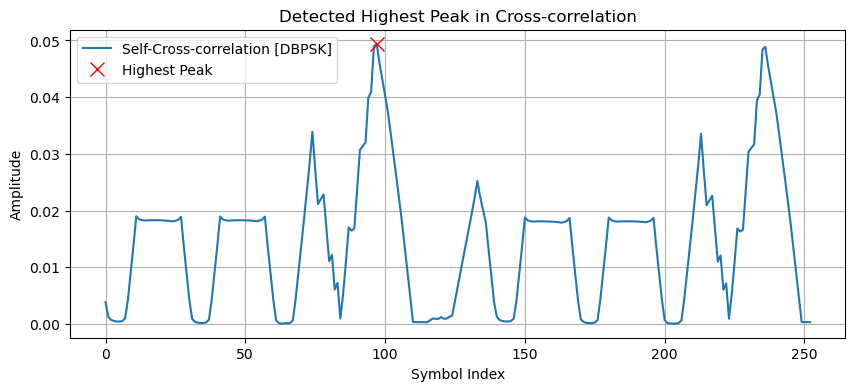

Peak index of highest peak: 97
Value of highest peak: 0.04942127671057961
Estimated CFO (Hz): 8.164300848461748
Angle_A :  -0.0006668715967478329
length of demod_bits:  100
41-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
42-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


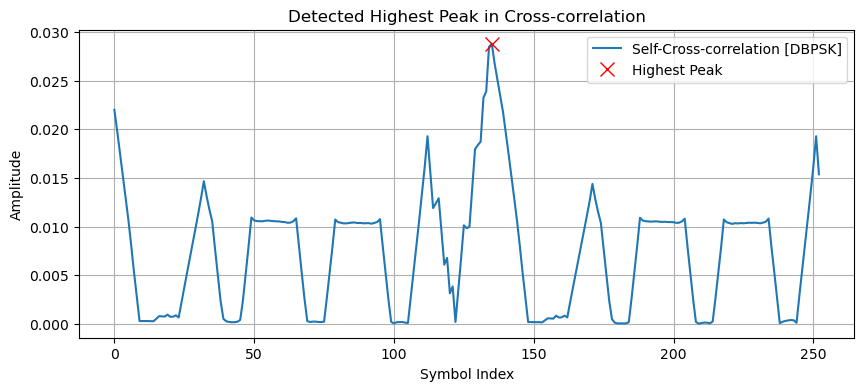

Peak index of highest peak: 135
Value of highest peak: 0.02877828735623499
Estimated CFO (Hz): -95.63359182607859
Angle_A :  0.007811486527447548
length of demod_bits:  100
42-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
43-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


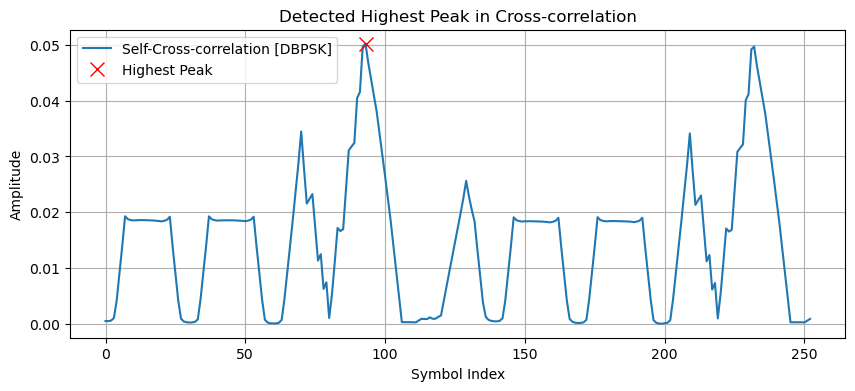

Peak index of highest peak: 93
Value of highest peak: 0.05020781134562704
Estimated CFO (Hz): 59.04284659985482
Angle_A :  -0.004822702901253458
length of demod_bits:  100
43-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
44-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


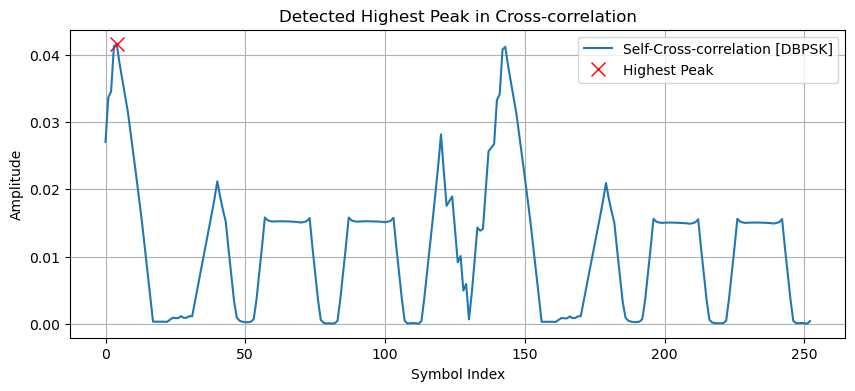

Peak index of highest peak: 4
Value of highest peak: 0.04161594804979982
Estimated CFO (Hz): -33.165734293841695
Angle_A :  0.0027090239074195476
length of demod_bits:  100
44-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
45-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


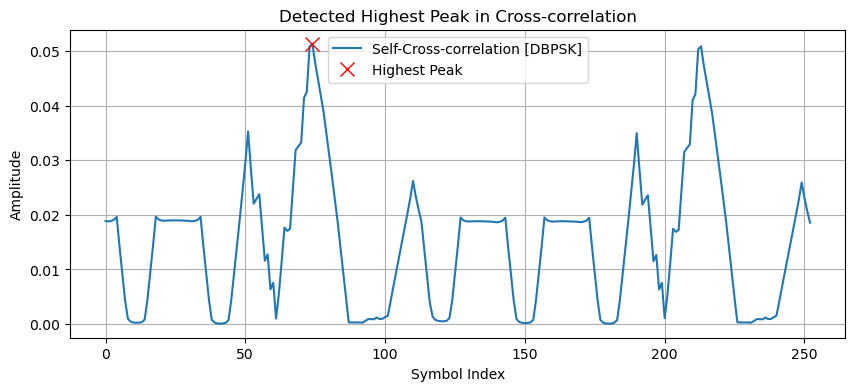

Peak index of highest peak: 74
Value of highest peak: 0.05139413177504302
Estimated CFO (Hz): 26.036571992542132
Angle_A :  -0.002126703885707235
length of demod_bits:  100
45-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
46-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


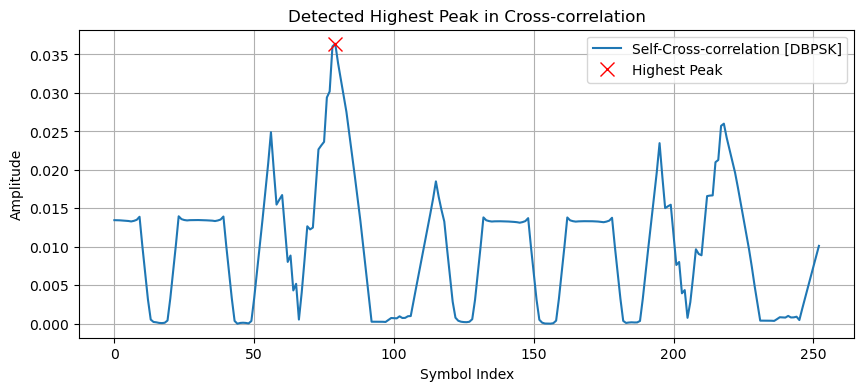

Peak index of highest peak: 79
Value of highest peak: 0.0363993125053444
Estimated CFO (Hz): 1.2442079415254244
Angle_A :  -0.00010162865774449316
length of demod_bits:  100
46-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
47-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


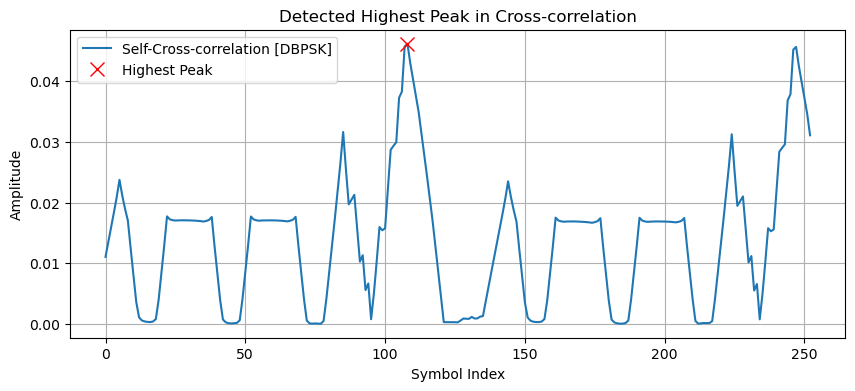

Peak index of highest peak: 108
Value of highest peak: 0.046175968857266436
Estimated CFO (Hz): 19.827895805444033
Angle_A :  -0.0016195704667616982
length of demod_bits:  100
47-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
48-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


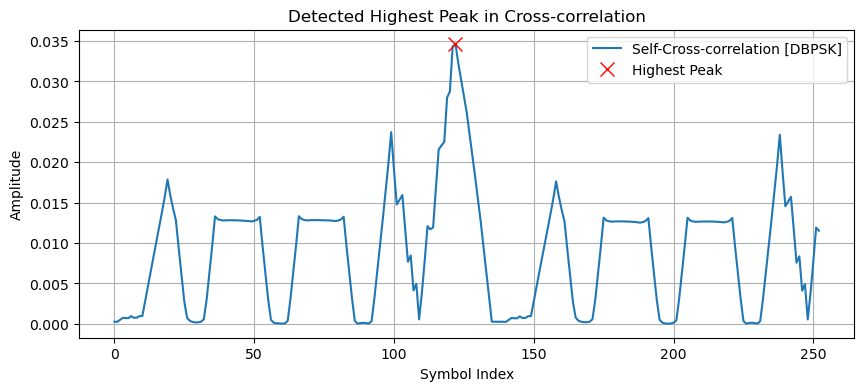

Peak index of highest peak: 122
Value of highest peak: 0.034674002907132837
Estimated CFO (Hz): -44.606699477203634
Angle_A :  0.0036435380638402356
length of demod_bits:  100
48-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
49-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


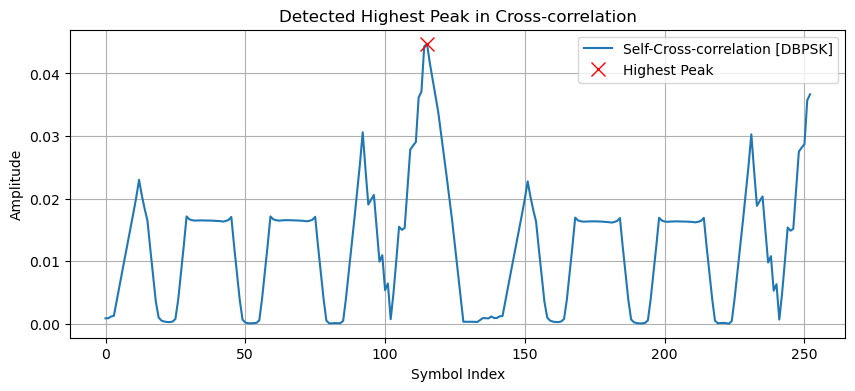

Peak index of highest peak: 115
Value of highest peak: 0.04474204990485616
Estimated CFO (Hz): -41.36915961972617
Angle_A :  0.0033790912466093964
length of demod_bits:  100
49-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
50-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


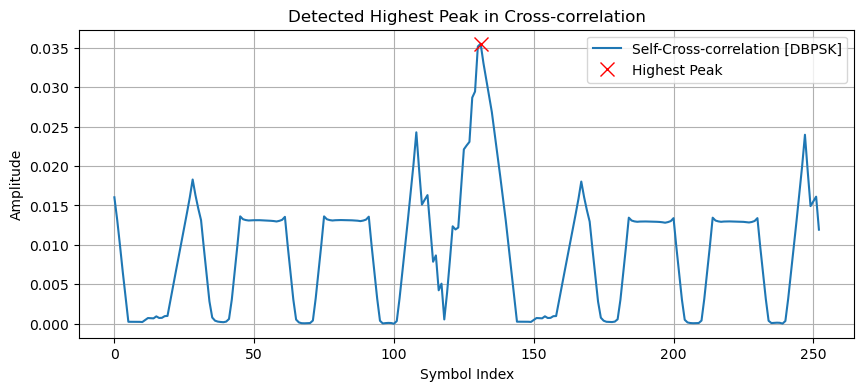

Peak index of highest peak: 131
Value of highest peak: 0.035512105345396595
Estimated CFO (Hz): -6.122173743332145
Angle_A :  0.0005000677774573673
length of demod_bits:  100
50-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
51-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


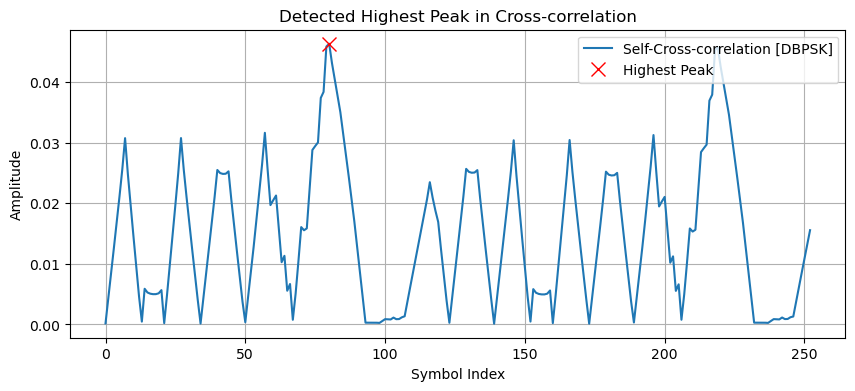

Peak index of highest peak: 80
Value of highest peak: 0.04634484382831038
Estimated CFO (Hz): -25.641506698137473
Angle_A :  0.002094434395815896
length of demod_bits:  100
51-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
52-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


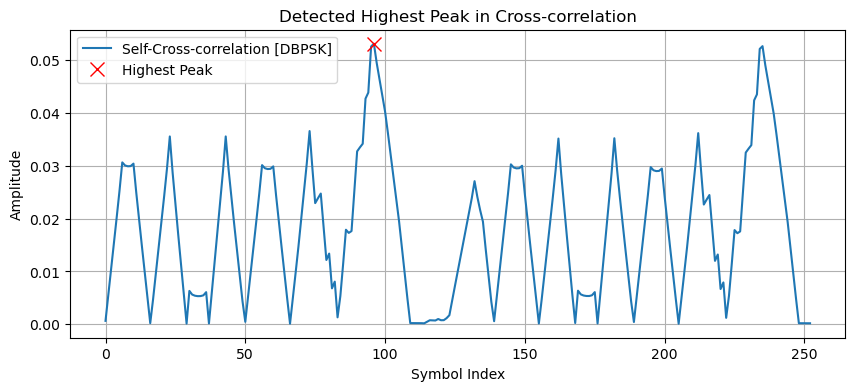

Peak index of highest peak: 96
Value of highest peak: 0.053126368105823385
Estimated CFO (Hz): -21.430079005264776
Angle_A :  0.0017504390479885059
length of demod_bits:  100
52-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
53-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


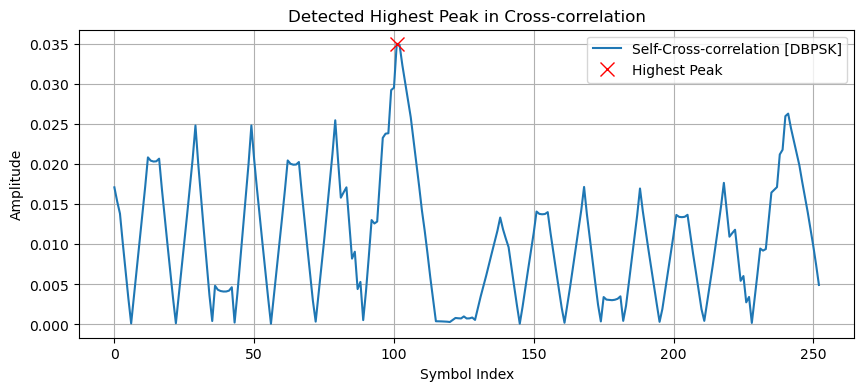

Peak index of highest peak: 101
Value of highest peak: 0.035042730727628396
Estimated CFO (Hz): 15.358821163007056
Angle_A :  -0.0012545301530710626
length of demod_bits:  100
53-th demodulated bits: [0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.05
--------------------------------------------------
54-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


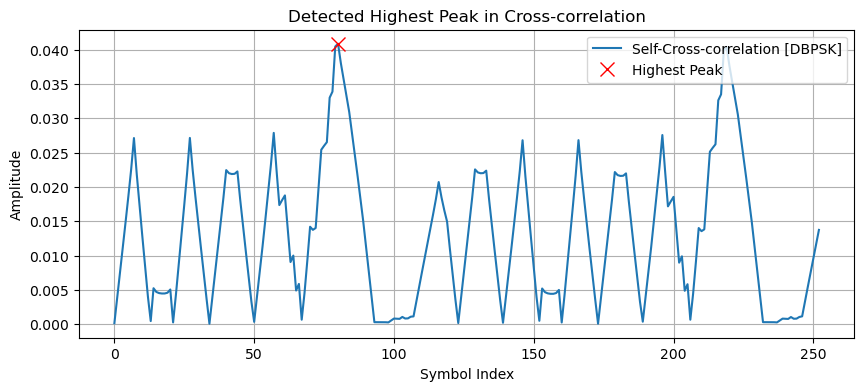

Peak index of highest peak: 80
Value of highest peak: 0.04084773151816414
Estimated CFO (Hz): 55.442419504132474
Angle_A :  -0.004528614943097077
length of demod_bits:  100
54-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
55-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


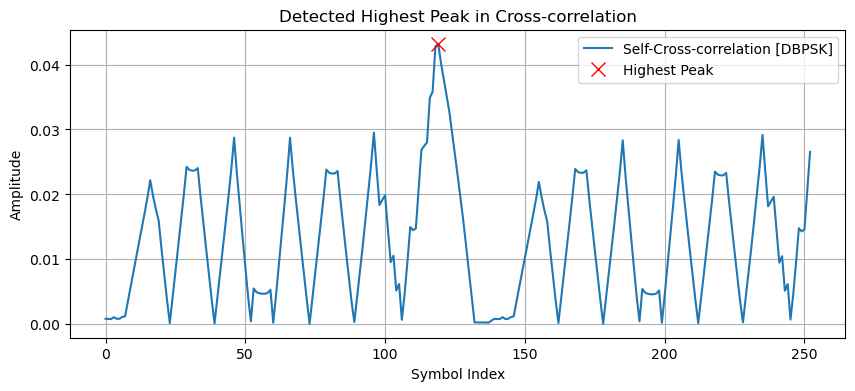

Peak index of highest peak: 119
Value of highest peak: 0.04320246970066564
Estimated CFO (Hz): -4.112891784726356
Angle_A :  0.0003359467960135595
length of demod_bits:  100
55-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
56-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


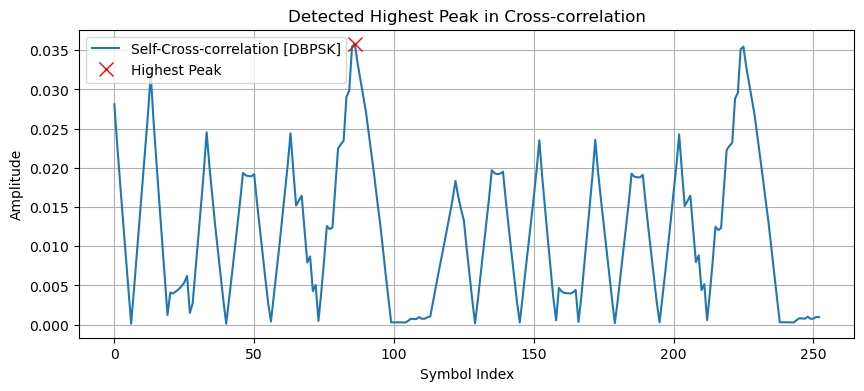

Peak index of highest peak: 86
Value of highest peak: 0.03583603833480563
Estimated CFO (Hz): -6.34427632371858
Angle_A :  0.0005182094291643867
length of demod_bits:  100
56-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
57-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


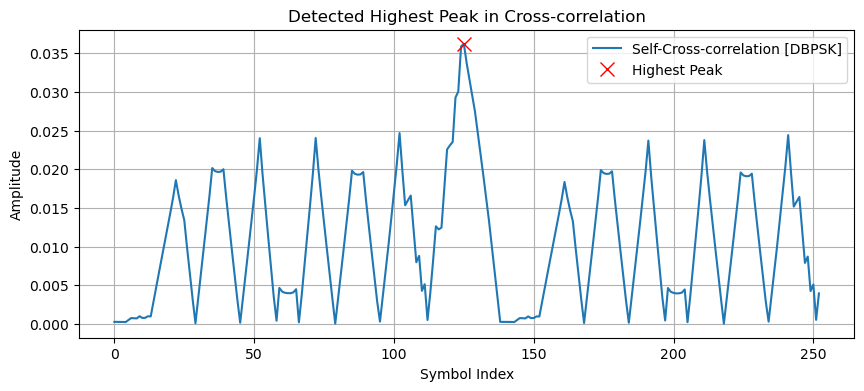

Peak index of highest peak: 125
Value of highest peak: 0.03622737736410907
Estimated CFO (Hz): 11.859079391509777
Angle_A :  -0.000968666314062336
length of demod_bits:  100
57-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
58-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


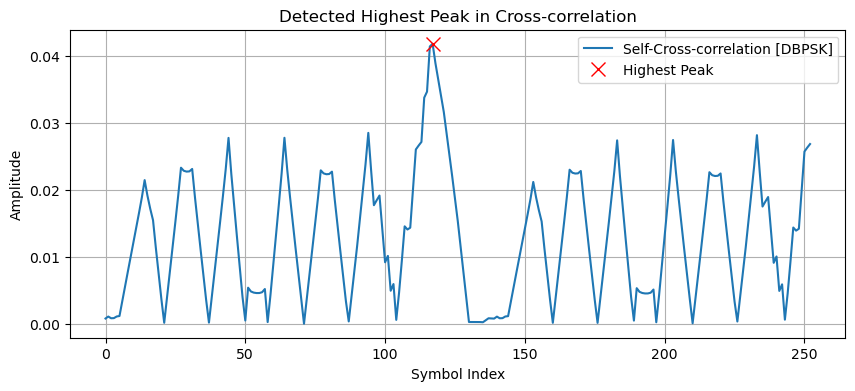

Peak index of highest peak: 117
Value of highest peak: 0.0418632337712319
Estimated CFO (Hz): 20.818157871330445
Angle_A :  -0.0017004564675759505
length of demod_bits:  100
58-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
59-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


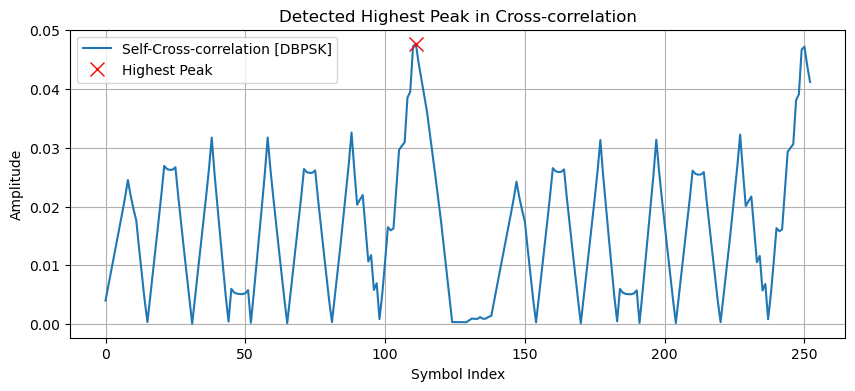

Peak index of highest peak: 111
Value of highest peak: 0.04772212974233558
Estimated CFO (Hz): 3.9259749660314927
Angle_A :  -0.00032067916689801135
length of demod_bits:  100
59-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
60-th packet symbols at TX-side: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


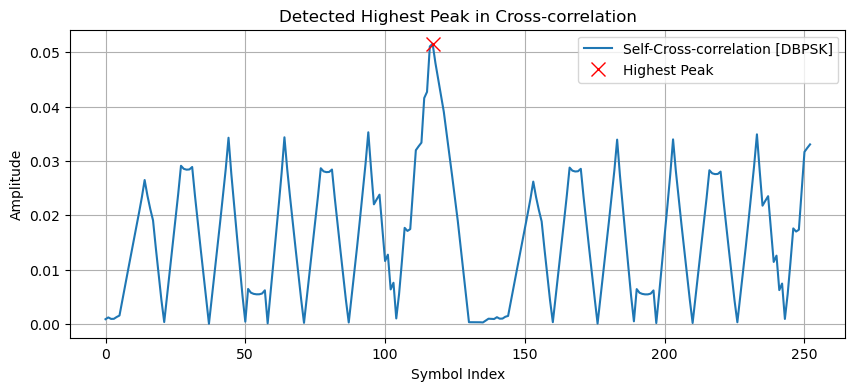

Peak index of highest peak: 117
Value of highest peak: 0.05157957123630315
Estimated CFO (Hz): -41.80589110350068
Angle_A :  0.003414764089555848
length of demod_bits:  100
60-th demodulated bits: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
61-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


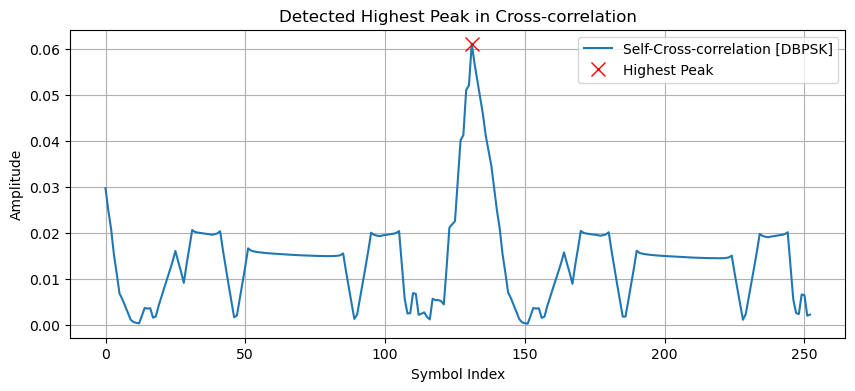

Peak index of highest peak: 131
Value of highest peak: 0.06121060120593873
Estimated CFO (Hz): 40.89001333258196
Angle_A :  -0.0033399539027615327
length of demod_bits:  100
61-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
62-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


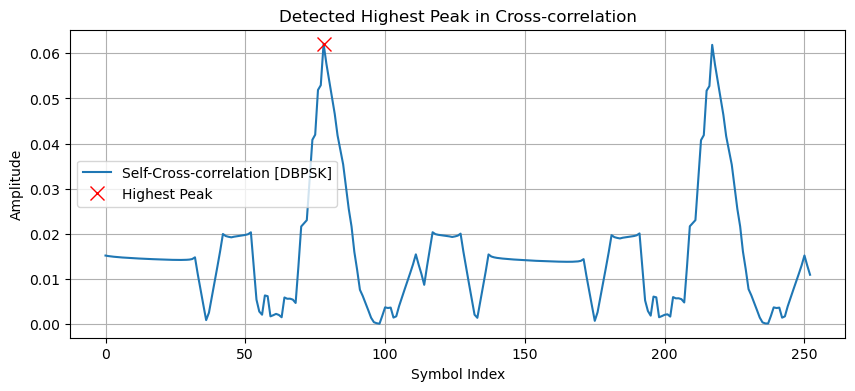

Peak index of highest peak: 78
Value of highest peak: 0.062131668203591325
Estimated CFO (Hz): 29.27602563741782
Angle_A :  -0.002391307023789275
length of demod_bits:  100
62-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
63-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


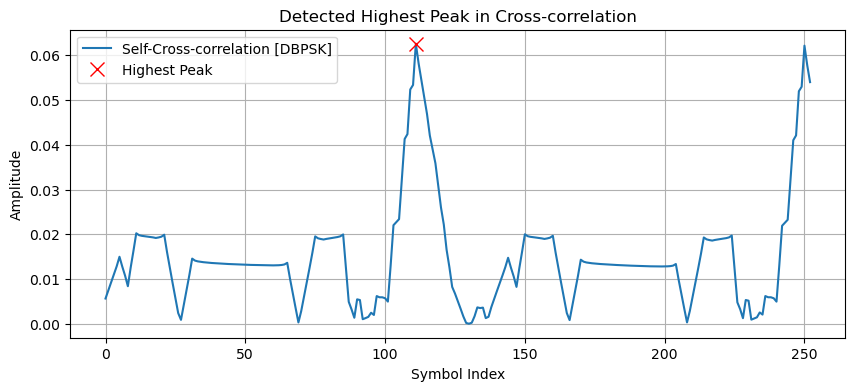

Peak index of highest peak: 111
Value of highest peak: 0.06256545509769798
Estimated CFO (Hz): 35.71605925425655
Angle_A :  -0.002917338043577103
length of demod_bits:  100
63-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
64-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


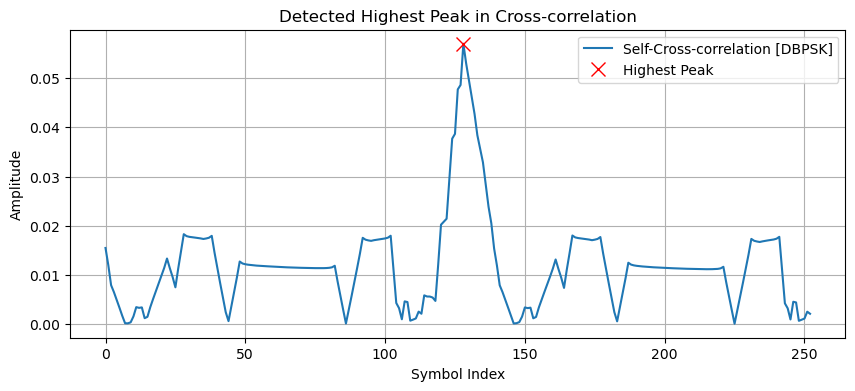

Peak index of highest peak: 128
Value of highest peak: 0.05702771439350967
Estimated CFO (Hz): 9.405788903523014
Angle_A :  -0.0007682780903336317
length of demod_bits:  100
64-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
65-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


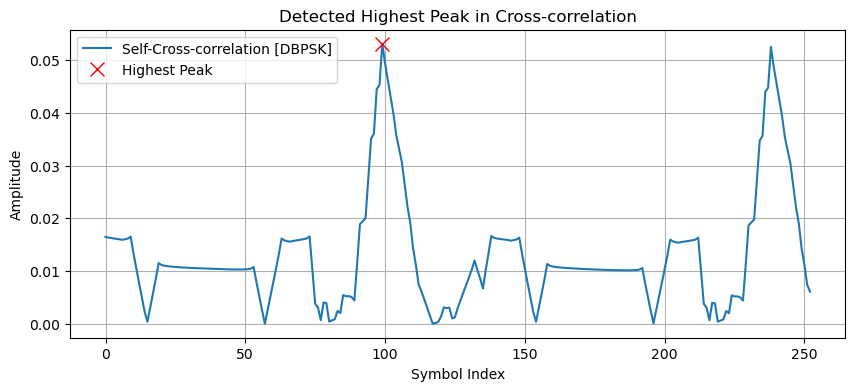

Peak index of highest peak: 99
Value of highest peak: 0.05309456706161762
Estimated CFO (Hz): -49.6745213327584
Angle_A :  0.004057484893529165
length of demod_bits:  100
65-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
66-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


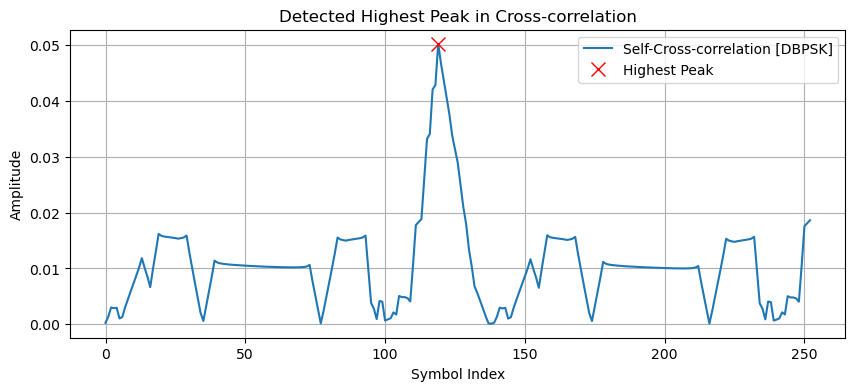

Peak index of highest peak: 119
Value of highest peak: 0.05028697643995618
Estimated CFO (Hz): -5.677481471229681
Angle_A :  0.00046374468610359075
length of demod_bits:  100
66-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
67-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


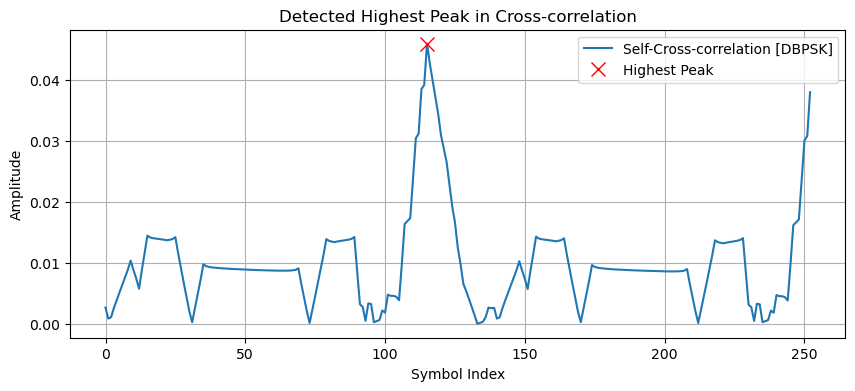

Peak index of highest peak: 115
Value of highest peak: 0.04601103165279857
Estimated CFO (Hz): 36.95315237474667
Angle_A :  -0.0030183855527146975
length of demod_bits:  100
67-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
68-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


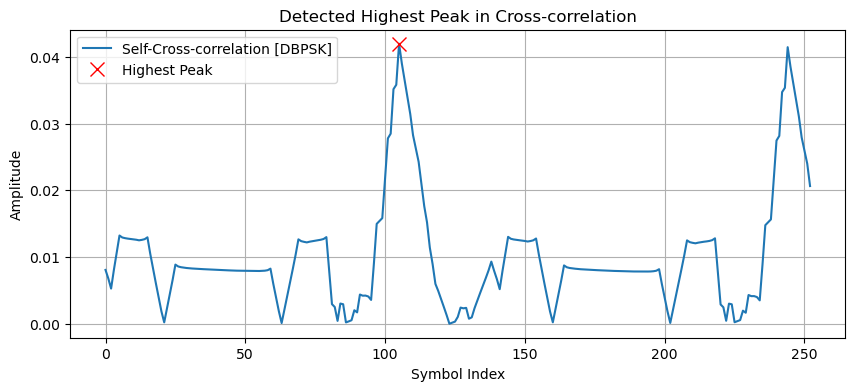

Peak index of highest peak: 105
Value of highest peak: 0.041950484215387024
Estimated CFO (Hz): -28.892820596680018
Angle_A :  0.002360006296128463
length of demod_bits:  100
68-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
69-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


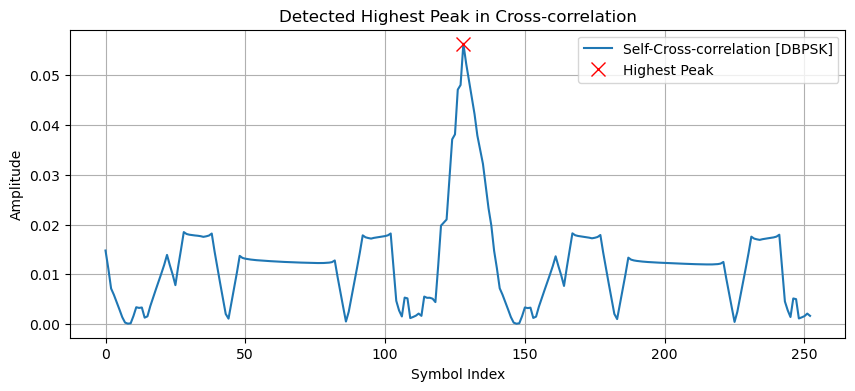

Peak index of highest peak: 128
Value of highest peak: 0.056363652508583405
Estimated CFO (Hz): 13.907952873568638
Angle_A :  -0.0011360211869259835
length of demod_bits:  100
69-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
70-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


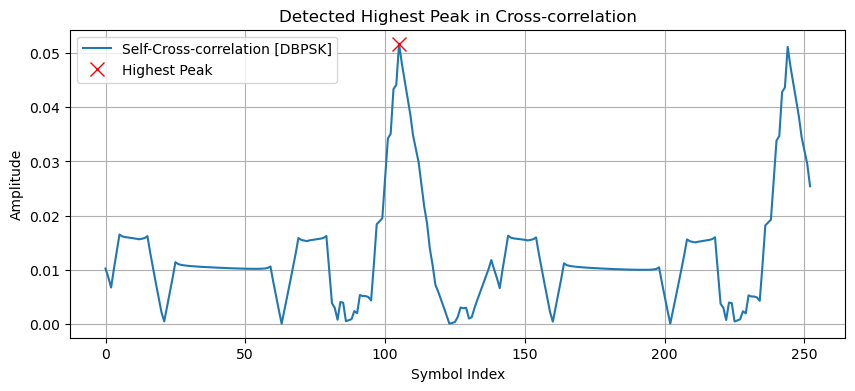

Peak index of highest peak: 105
Value of highest peak: 0.05173976614337736
Estimated CFO (Hz): -3.936689533188756
Angle_A :  0.00032155434784017034
length of demod_bits:  100
70-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
71-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


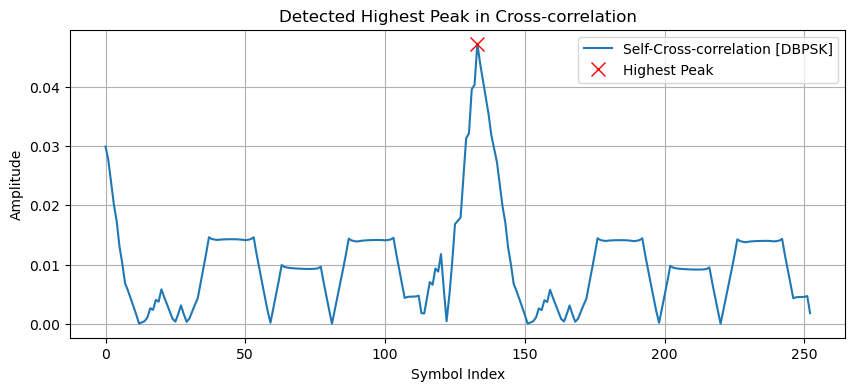

Peak index of highest peak: 133
Value of highest peak: 0.0472355052577908
Estimated CFO (Hz): 3.0491617680677527
Angle_A :  -0.00024905982946438145
length of demod_bits:  100
71-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
72-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


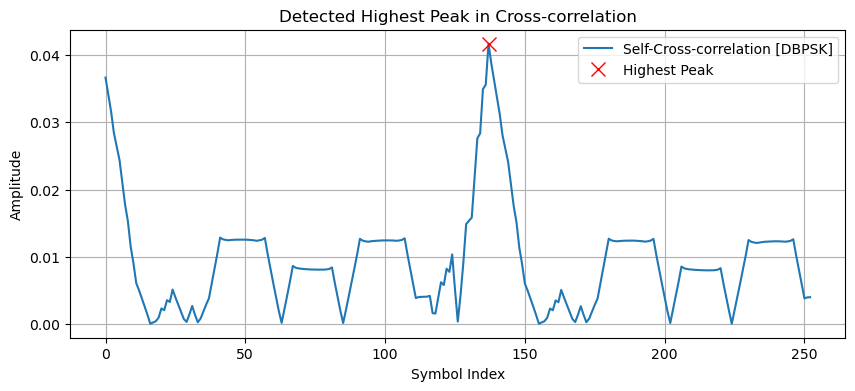

Peak index of highest peak: 137
Value of highest peak: 0.04169460778391494
Estimated CFO (Hz): -42.69297700062289
Angle_A :  0.0034872225155309065
length of demod_bits:  100
72-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
73-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


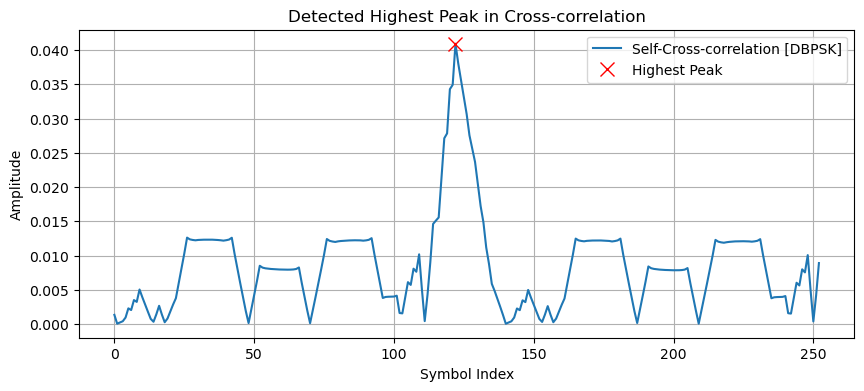

Peak index of highest peak: 122
Value of highest peak: 0.04092444775717315
Estimated CFO (Hz): 25.481535360368643
Angle_A :  -0.0020813677115483894
length of demod_bits:  100
73-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
74-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


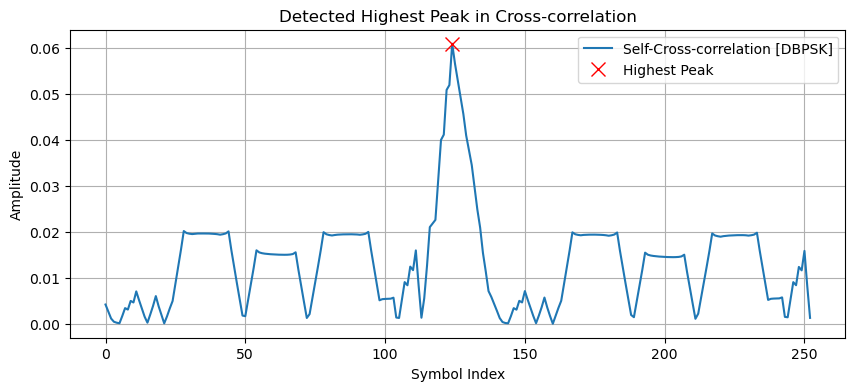

Peak index of highest peak: 124
Value of highest peak: 0.06095671831219259
Estimated CFO (Hz): -5.200709840740056
Angle_A :  0.0004248013075571487
length of demod_bits:  100
74-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
75-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


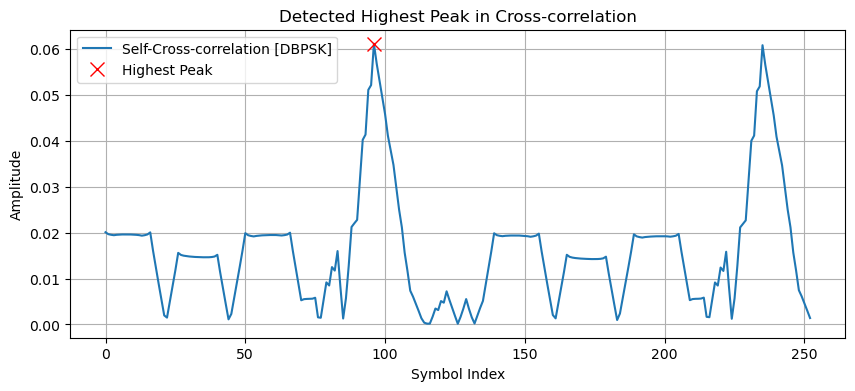

Peak index of highest peak: 96
Value of highest peak: 0.06121717022765365
Estimated CFO (Hz): 0.30471017626303987
Angle_A :  -2.4889156531772443e-05
length of demod_bits:  100
75-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
76-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


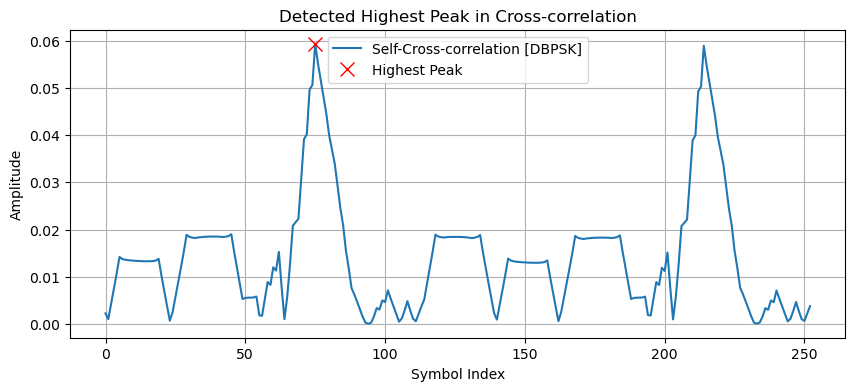

Peak index of highest peak: 75
Value of highest peak: 0.05937467011078361
Estimated CFO (Hz): -3.485781723413567
Angle_A :  0.0002847235626116344
length of demod_bits:  100
76-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
77-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


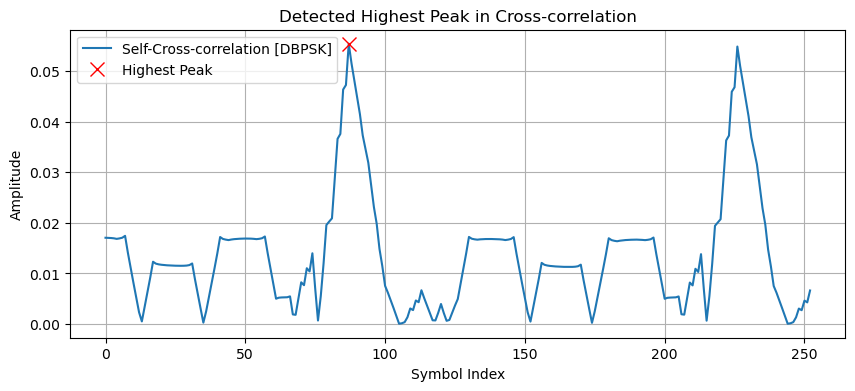

Peak index of highest peak: 87
Value of highest peak: 0.05540581420345757
Estimated CFO (Hz): 0.1234732326283438
Angle_A :  -1.0085467614044899e-05
length of demod_bits:  100
77-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
78-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


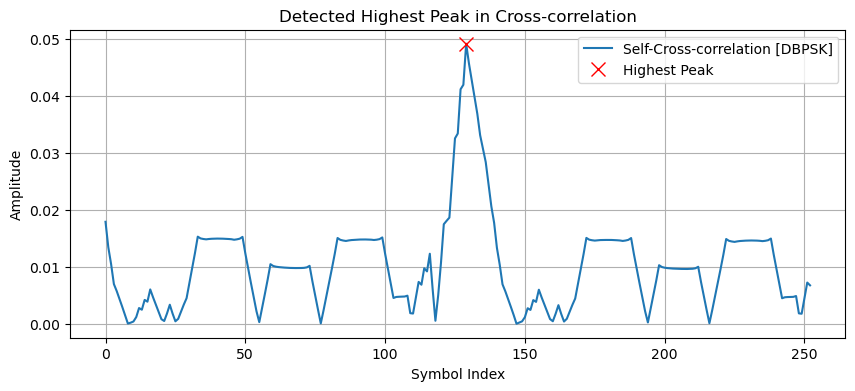

Peak index of highest peak: 129
Value of highest peak: 0.04908870926265047
Estimated CFO (Hz): 1.122334266376741
Angle_A :  -9.167384423915275e-05
length of demod_bits:  100
78-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
79-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


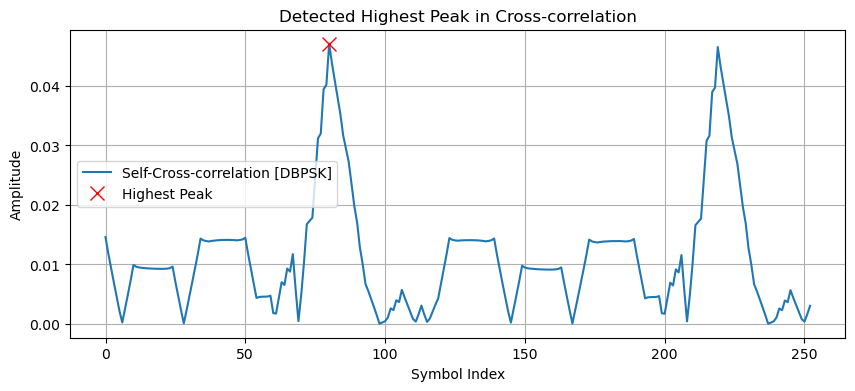

Peak index of highest peak: 80
Value of highest peak: 0.047104079580513554
Estimated CFO (Hz): -1.3913460127130424
Angle_A :  0.00011364710271565937
length of demod_bits:  100
79-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
80-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


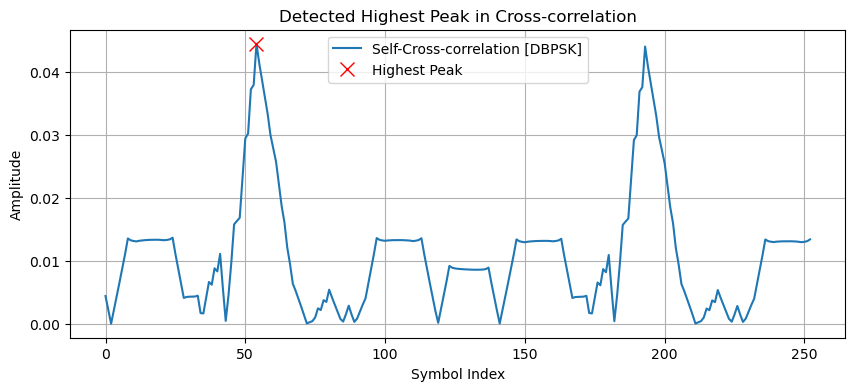

Peak index of highest peak: 54
Value of highest peak: 0.04455716562412457
Estimated CFO (Hz): 32.08397101942015
Angle_A :  -0.002620663958967552
length of demod_bits:  100
80-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
81-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


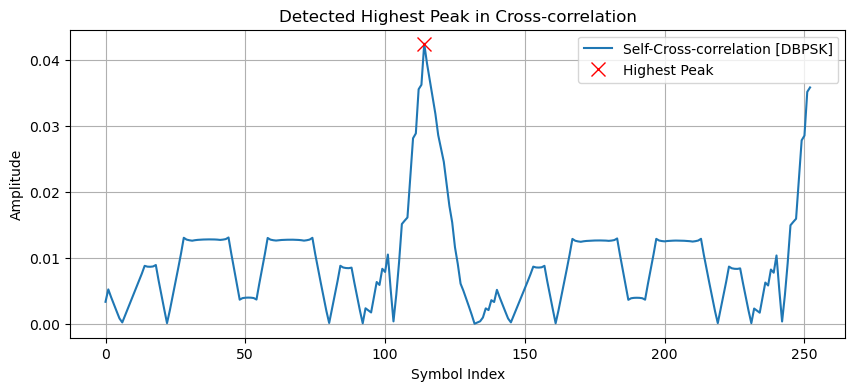

Peak index of highest peak: 114
Value of highest peak: 0.042498925936900786
Estimated CFO (Hz): 17.43112179453036
Angle_A :  -0.0014237985885116632
length of demod_bits:  100
81-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
82-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


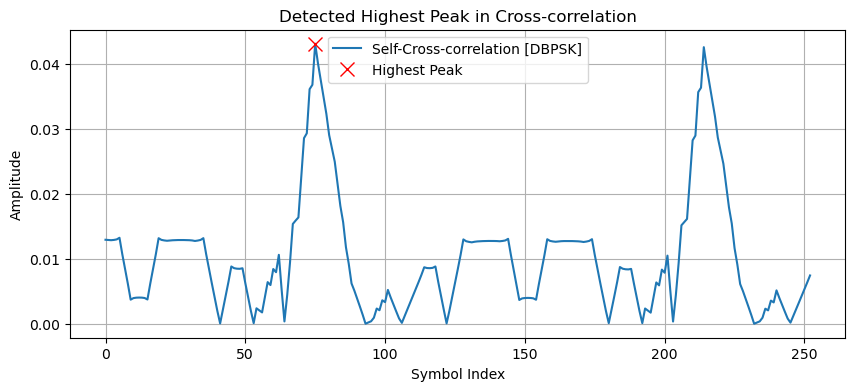

Peak index of highest peak: 75
Value of highest peak: 0.04308483018023381
Estimated CFO (Hz): -22.788537312634684
Angle_A :  0.0018613998365931803
length of demod_bits:  100
82-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
83-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


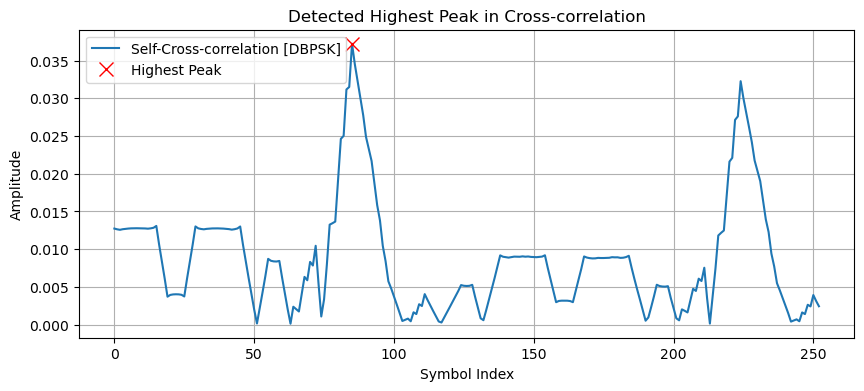

Peak index of highest peak: 85
Value of highest peak: 0.03723817265832092
Estimated CFO (Hz): 99.75969166384425
Angle_A :  -0.008148512175843416
length of demod_bits:  100
83-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
84-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


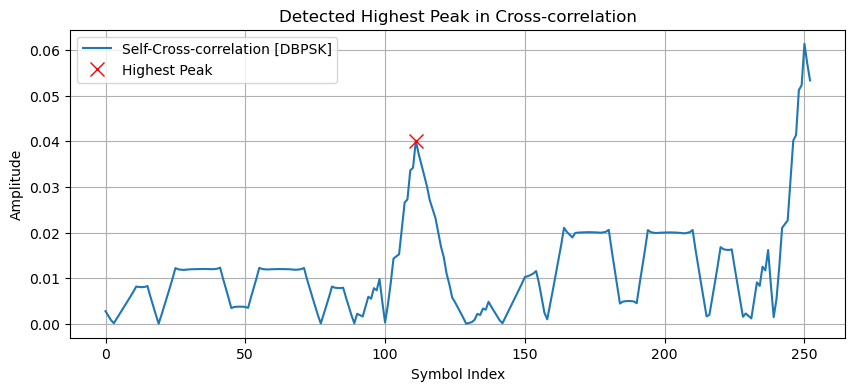

Peak index of highest peak: 111
Value of highest peak: 0.04013873282458148
Estimated CFO (Hz): 41.88219369751118
Angle_A :  -0.003420996592944472
length of demod_bits:  100
84-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
85-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


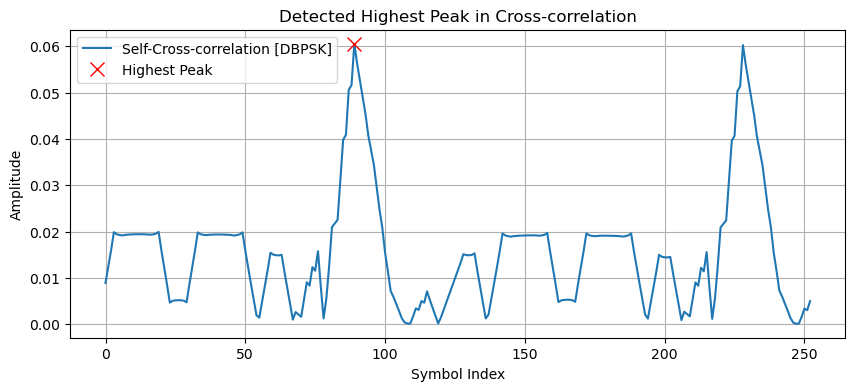

Peak index of highest peak: 89
Value of highest peak: 0.06054824328677835
Estimated CFO (Hz): -13.094386318028057
Angle_A :  0.0010695679243595748
length of demod_bits:  100
85-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
86-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


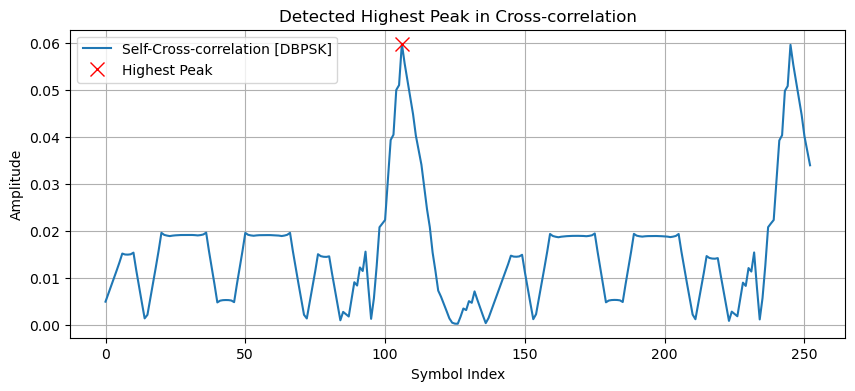

Peak index of highest peak: 106
Value of highest peak: 0.05981830643752353
Estimated CFO (Hz): -15.796131363581091
Angle_A :  0.0012902502664211076
length of demod_bits:  100
86-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
87-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


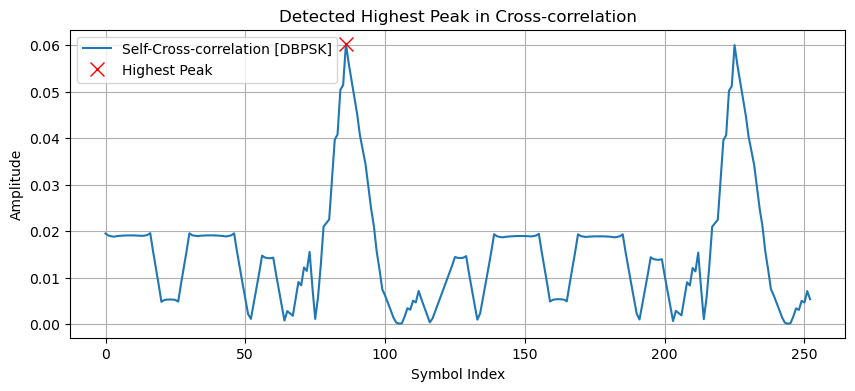

Peak index of highest peak: 86
Value of highest peak: 0.060352549703973114
Estimated CFO (Hz): 6.381011431499349
Angle_A :  -0.0005212100045274419
length of demod_bits:  100
87-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
88-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


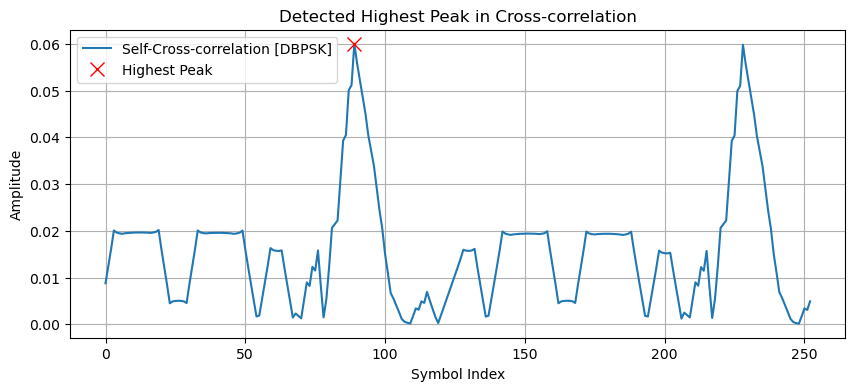

Peak index of highest peak: 89
Value of highest peak: 0.060020825582370305
Estimated CFO (Hz): 27.848979753709784
Angle_A :  -0.002274743905309864
length of demod_bits:  100
88-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
89-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


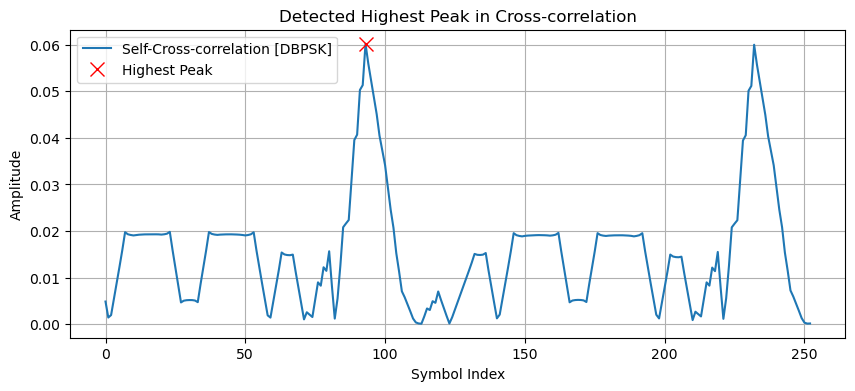

Peak index of highest peak: 93
Value of highest peak: 0.06018411720996325
Estimated CFO (Hz): -6.010875449602045
Angle_A :  0.0004909767760069388
length of demod_bits:  100
89-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
90-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


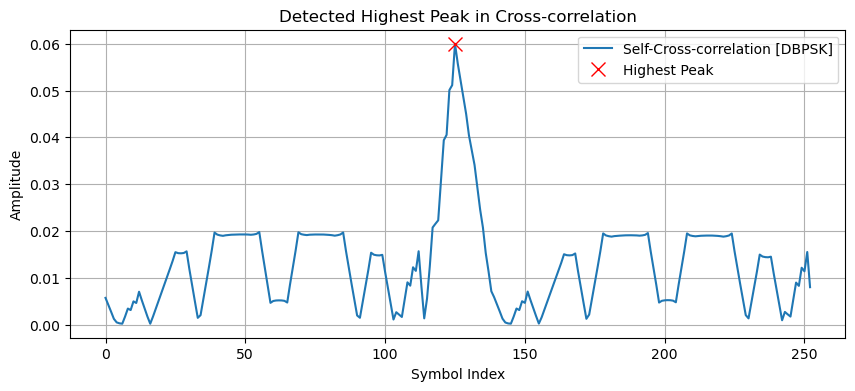

Peak index of highest peak: 125
Value of highest peak: 0.060014472090005405
Estimated CFO (Hz): 34.287904478552804
Angle_A :  -0.0028006843492370615
length of demod_bits:  100
90-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
91-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


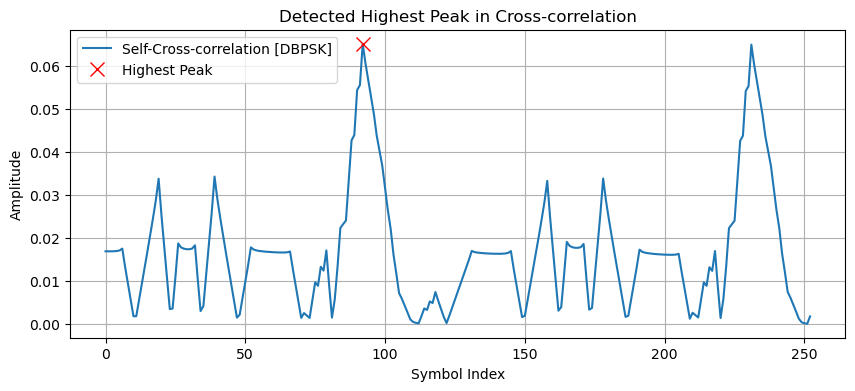

Peak index of highest peak: 92
Value of highest peak: 0.06509773317725262
Estimated CFO (Hz): 55.210384186114304
Angle_A :  -0.004509661971385136
length of demod_bits:  100
91-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
92-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


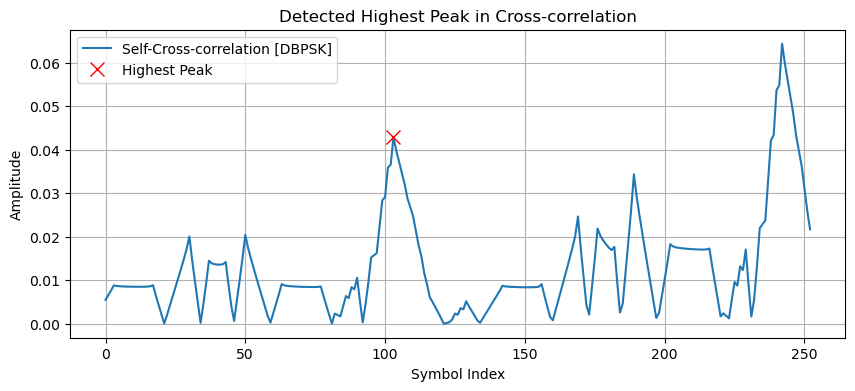

Peak index of highest peak: 103
Value of highest peak: 0.04283240311652084
Estimated CFO (Hz): -19.551704608232903
Angle_A :  0.001597010780621937
length of demod_bits:  100
92-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
93-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


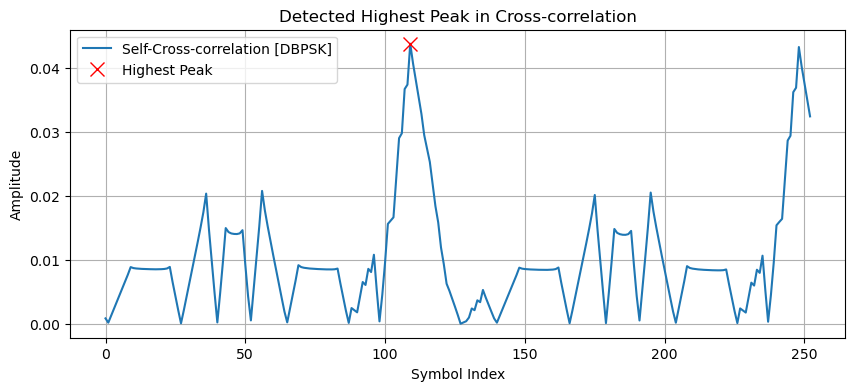

Peak index of highest peak: 109
Value of highest peak: 0.04383684780169208
Estimated CFO (Hz): -12.597085356340125
Angle_A :  0.0010289476811151642
length of demod_bits:  100
93-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
94-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


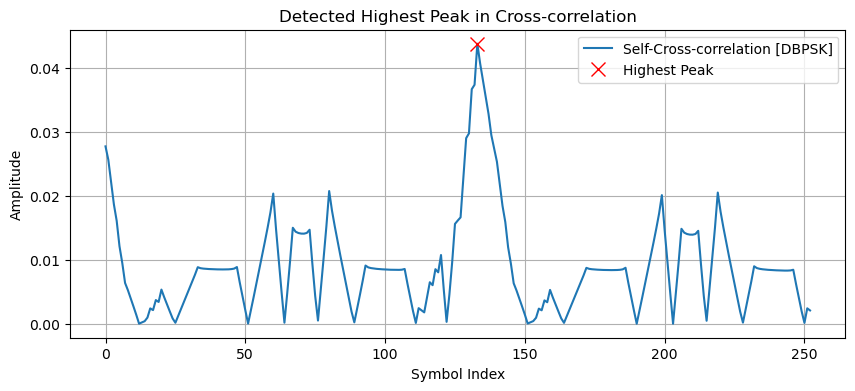

Peak index of highest peak: 133
Value of highest peak: 0.043747578703483884
Estimated CFO (Hz): 14.50140597909032
Angle_A :  -0.0011844952727564646
length of demod_bits:  100
94-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
95-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


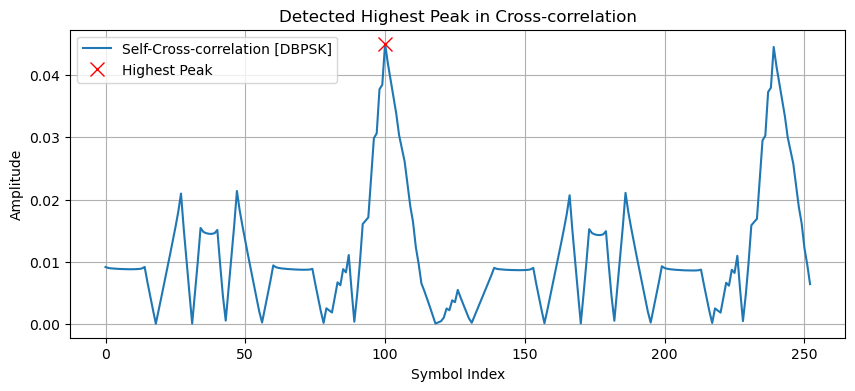

Peak index of highest peak: 100
Value of highest peak: 0.04503506153670272
Estimated CFO (Hz): 2.6330523365228142
Angle_A :  -0.00021507142480037535
length of demod_bits:  100
95-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
96-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


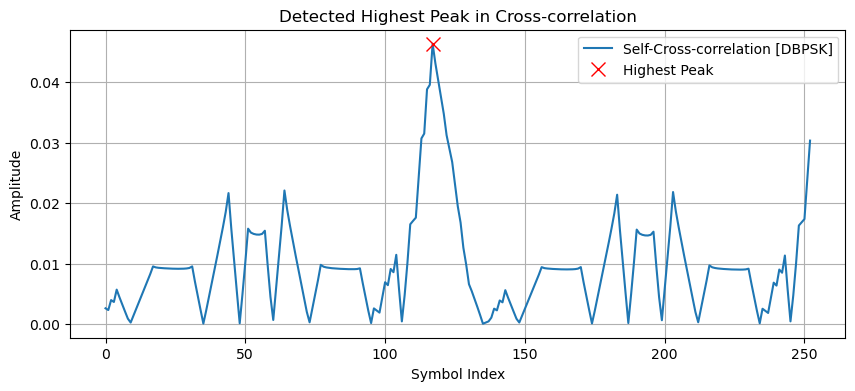

Peak index of highest peak: 117
Value of highest peak: 0.04635911516408286
Estimated CFO (Hz): -35.125234491482615
Angle_A :  0.0028690786444855758
length of demod_bits:  100
96-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
97-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


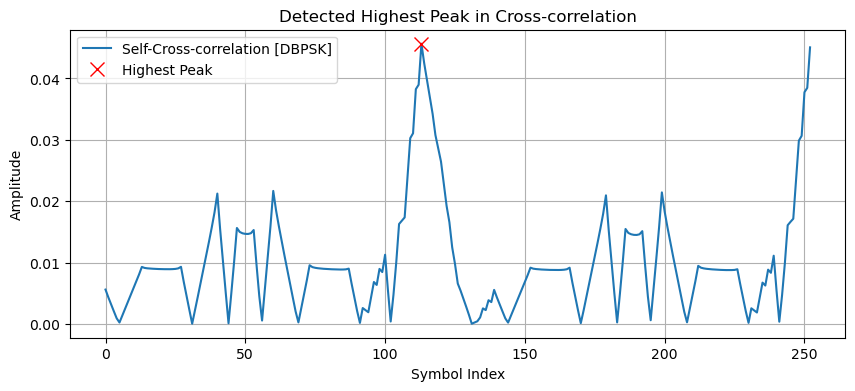

Peak index of highest peak: 113
Value of highest peak: 0.04566050429166916
Estimated CFO (Hz): -21.720799592538693
Angle_A :  0.001774185515180409
length of demod_bits:  100
97-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
98-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


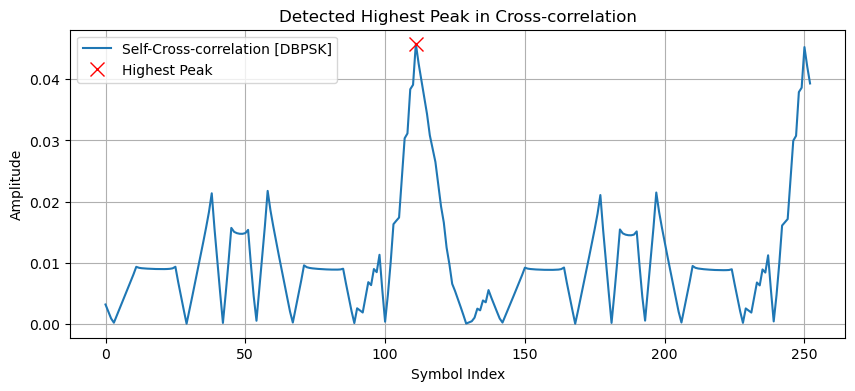

Peak index of highest peak: 111
Value of highest peak: 0.04581174186863684
Estimated CFO (Hz): -48.58064294253205
Angle_A :  0.003968135365348116
length of demod_bits:  100
98-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
99-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


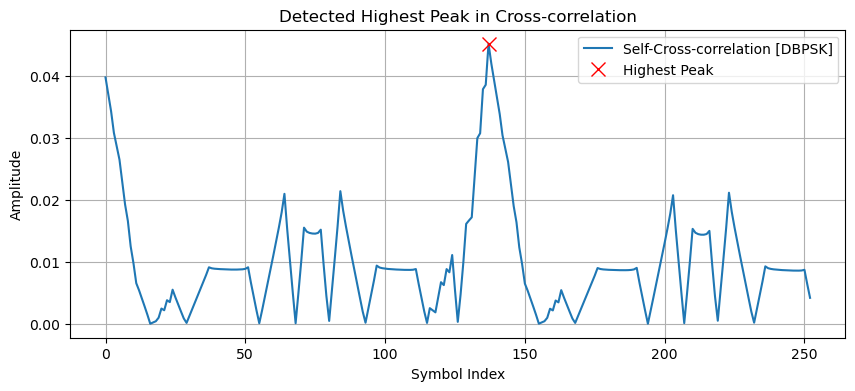

Peak index of highest peak: 137
Value of highest peak: 0.04526332824075844
Estimated CFO (Hz): 10.126433785168487
Angle_A :  -0.0008271413796502688
length of demod_bits:  100
99-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------
100-th packet symbols at TX-side: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


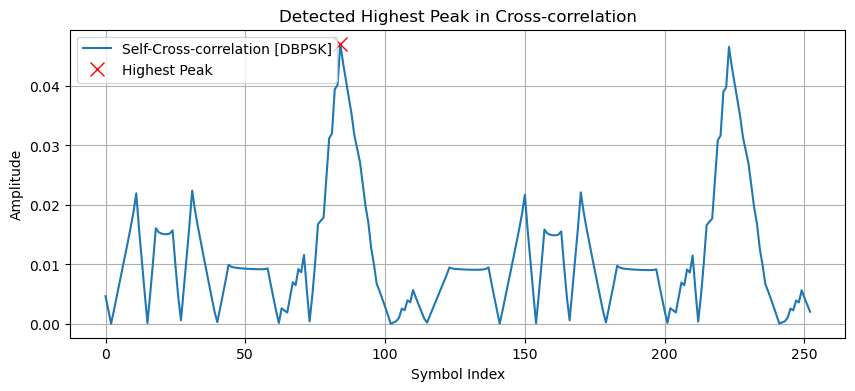

Peak index of highest peak: 84
Value of highest peak: 0.0470986869014278
Estimated CFO (Hz): -47.83226960543599
Angle_A :  0.003907007176721065
length of demod_bits:  100
100-th demodulated bits: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (Length: 100)
Packet BER: 0.0
--------------------------------------------------


In [109]:
import time
# Transmission Loop
for g in range(num_packets):


    # Step 1: Extract Packet (symbols)
    packet_symbols = mqam_symbols[g * symbols_per_packet : (g + 1) * symbols_per_packet]
    # Print the packet index and its symbols
    print(f"{g + 1}-th packet symbols at TX-side: {packet_symbols}")

    
    # Step 2: Add Barker Preamble and Guard Band
    # Barker sequence is already in +1 and -1 form, no need to remap
    preamble_symbols = barker_13  # Directly use the Barker sequence
    guard_band_symbols = np.zeros(len(guard_band))  # Zero guard band for separation
    
   
    
    # Step 3: Concatenate preamble, guard band, and data symbols
    tx_frame = np.concatenate((preamble_symbols,preamble_symbols, guard_band_symbols, packet_symbols))

    
    
    # Step 4: Upsampling the full frame by sps (insert sps-1 zeros between each symbol)
    up_sym = np.zeros(len(tx_frame) * sps, dtype = complex)  # Create an array of zeros
    up_sym[::sps] = tx_frame  # Insert symbols into every sps-th position
  
    
    # Step 5: Pulse Shaping (optional but strongly recommended)
    ## Parameters for RRC filter ##
    N = len(up_sym)   # Filter length in terms of samples per symbol = length of upsampled symbol for frame
    alpha = 1  # Roll-off factor 
    f_sym = fs/sps   # Symbol rate =  [fs] /[sps]  sampling rate / number of samples
                     # sampling rate = symbol_rate * number of samples ( symbol factor)
    
    ## Calculate Ts (symbol period) and Fs (sampling rate)
    Ts = 1 / f_sym         # Symbol period in seconds (1 microsecond for 1 MHz)
    Fs = sps * f_sym       # Sampling rate in Hz  = number of samples * symbol rate
    
    ## Generate RRC filter
    time_idx, rrc_filter = rrcosfilter(N, alpha, Ts, Fs)
    
    
    ## Pulse shaping by convolving upsampled symbols with RRC filter
    your_Tx_samples = np.convolve(up_sym, rrc_filter, mode='same')


    
    
    # Step 6: Transmit through SDR
    ## Scale and transmit pulse-shaped samples 
    tx_samples = your_Tx_samples * 2**14  # Scale for SDR transmission
    sdr.tx_cyclic_buffer = True # Enable continuous transmission
    sdr.tx(tx_samples)

    # Adding a delay between transmissions (adjust as needed)
    time.sleep(0.5)  # 0.5 seconds delay
    
    # ------------------------------- Receiver Side ---------------------
    # Step 7: Receive the Signal
    ###################### Receive samples #########################
    sdr.rx_buffer_size = 2 * tx_samples.size  # Set buffer size for reception

    # Clear the buffer to avoid stale data
    for i in range(5):
        sdr.rx()  # Clear stale buffer data

    # Receive the transmitted signal
    rx_samples_raw = sdr.rx()
    rx_samples = rx_samples_raw * 2**-14  # Scale received samples back down

    # Stop transmitting
    sdr.tx_destroy_buffer()



    
    # Step 8: Matched Filtering and Frame Synchronization
    ## Apply matched filtering using the same RRC filter 
    rx_matched = np.convolve(rx_samples, rrc_filter, mode='same')



    

    # Step 9 : Time Recovery for rx_matched
    ##Time recovery for rx_matched ######################## 
    
    # Maximum energy approach for symbol timing recovery
    energy = np.zeros(sps)
    
    # Compute the energy across different offsets
    for k in range(sps):
        # Take every sps-th sample starting from the k-th sample and compute energy
        energy[k] = np.sum(np.abs(rx_samples[k::sps])**2)  # Sum of squared magnitudes
    
    # Find the offset that maximizes the energy
    max_ind = np.argmax(energy)
    
    # Align the samples using the offset with the maximum energy
    rx_align = rx_samples[max_ind:] 

    # covnert align to symbol
    ####  
    ## Downsampling (Must be done after Time recovery but before frame synch) to covnert samples to symbols ####################

    rx_align_symbol = rx_align[::sps]






    
    # Step 10 : Self-reference frame synch ################################################

    rx_cfo = rx_align_symbol
    
    ####################### Self-reference frame synch ########################
    
    num_symbols = len(mqam_symbols)
    
    
    from scipy.signal import find_peaks
    
    # Define Barker sequence length
    N = len(barker_13)  # Barker-13 sequence length
    
    ######### Self-reference frame sync ##############
    corr = np.zeros(rx_cfo.size - 2 * N + 1)
    for n in range(len(corr)):
        # Compute the correlation for each possible start position
        corr[n] = np.abs(np.sum(np.conj(rx_cfo[n:n+N]) * rx_cfo[n+N:n+2*N]))
    
    # Use find_peaks to detect the peak
    # Limit the range to look for peaks within the first 60 indices
    limited_corr = corr[:150]  # Slice to limit to the first 60 indices
    peaks, _ = find_peaks(limited_corr)
    
    # Identify the first occurrence of the highest peak
    max_peak_value = np.max(limited_corr[peaks])  # Maximum peak value in correlation
    first_highest_peak = peaks[np.where(limited_corr[peaks] == max_peak_value)[0][0]]  # First occurrence of max peak
    
    # Now set peak_index to this first highest peak
    peak_index = first_highest_peak
    
    # Find out the frame, then split it into preamble and data (no need to adjust `peak_index`) why?
    rx_frame = rx_cfo[peak_index:peak_index + 2 * N + len(guard_band) + num_symbols]
    rx_preamble = rx_frame[ : 2 * N]  # First two Barker sequences
    rx_data = rx_frame[2 * N + len(guard_band):]  # Data symbols after preamble and guard band


    ####################### Lab 8 : Self-reference frame synch ################################################
    # Plot cross-correlation
    plt.figure(figsize=(10, 4))
    plt.plot(corr, label='Self-Cross-correlation [DBPSK]')  # Plot the entire correlation
    plt.plot(peak_index, corr[peak_index], 'rx', label='Highest Peak', markersize=10)  # Mark only the highest peak
    plt.title('Detected Highest Peak in Cross-correlation')
    plt.xlabel('Symbol Index')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    print("Peak index of highest peak:", peak_index)
    print("Value of highest peak:", corr[peak_index])




    
    # Step 11: Estimate CFO
    ######################### Estimate CFO ##################################
    
    # Step 11-1: Compute A
    N = len(barker_13)
    A = np.sum(np.conj(rx_preamble[:N]) * rx_preamble[N:2*N]) 
    
    # Step 11-2: Estimate CFO
    # symbol rate = 1/sampling rate <- as it is symbol originally
    T_s = 1/fs
    
    angle_A = np.angle(A)  # Extract the phase angle of A
    delta_fc = -angle_A / (2 * np.pi * N * T_s)  # CFO in Hz
    
    # Print results
    print(f"Estimated CFO (Hz): {delta_fc}")
    
    print("Angle_A : ",angle_A)
    
    # Step 11-3: Compute the maximum detectable CFO range
    max_cfo_range = 1 / (2 * N * T_s)
    cfo_range = (-max_cfo_range, max_cfo_range)
    

    # Step 11-4: CFO Correction
    rx_preamble_cor_afterCFO = np.zeros(len(rx_preamble), dtype=complex)
    rx_data_cor_afterCFO = np.zeros(len(rx_data), dtype=complex)
    rx_frame_cor_afterCFO = np.zeros(len(rx_frame), dtype=complex)
    
       
    # Assuming delta_fc (estimated CFO in Hz) and T_s (symbol period) are defined
    for k in range(len(rx_frame)):
        rx_frame_cor_afterCFO[k] = rx_frame[k] * np.exp(1j * 2 * np.pi * delta_fc * k * T_s)  # Apply CFO correction
    
    rx_preamble_cor_afterCFO = rx_frame_cor_afterCFO[:len(rx_preamble)]
    rx_data_cor_afterCFO = rx_frame_cor_afterCFO[-len(rx_data):] # from right, starting at len(rx_data) shift left




    



    #Step 12 : Channel Estimation
    # Step 12-1: Estimate the channel using the preamble  
    L = 1
    tx_preamble = np.concatenate((barker_13, barker_13,))
    hhat = estimate_h(rx_preamble_cor_afterCFO, tx_preamble, L)
    
    # Step 12-2: Correct channel by simple division
    rx_data_corrected_afterChannelEQ = rx_data_cor_afterCFO / hhat  # Apply the inverse of the estimated channel










    
    # Step 13: Demodulation (M-QAM Demodulation)
    # Assume demodulate_mqam is a function that demaps the received symbols to bits
    #decoded_bits = demodulate_mqam(packet_symbols, M)  # M = 2, 4, or 16 based on modulation

    ####################### Demodulation ##########################
    
    # Implement Demodulation to retrieve bits from symbols
    # Input: mqam_symbols (received symbols after transmission, possibly with noise)
    # Output: demod_bits (demodulated bit sequence that should match the transmitted bits)
    
    # Initialize an empty list to store the demodulated bits
    demod_bits = []
    
    # Iterate over each received symbol in the `mqam_symbols` array
    for symbol in rx_data_corrected_afterChannelEQ :
        # Initialize minimum distance to infinity for each symbol
        # This ensures that any calculated distance will be smaller initially
        min_distance = float('inf')
        
        # Initialize closest_bits to None; this will hold the bits of the closest constellation point
        closest_bits = None
        
        # Iterate over each possible constellation point in the gray_mapping
        # gray_mapping contains bit patterns as keys and complex symbols as values
        for bits_tuple, mapped_symbol in gray_mapping.items():
            
            # Calculate the Euclidean distance between the received symbol and the current constellation point
            # Normalization factor is applied to match the scale used in modulation
            distance = abs(symbol - mapped_symbol / normalization_factor)
            
            # Check if the calculated distance is the smallest one found so far
            if distance < min_distance:
                
                # Update min_distance to the new smaller distance
                min_distance = distance
                
                # Store the corresponding bit pattern of the closest constellation point
                closest_bits = bits_tuple
    
        
        # After finding the closest constellation point for this symbol,
        # append its corresponding bit pattern to demod_bits
        # closest_bits is a tuple, so extend() adds each bit individually to demod_bits
        demod_bits.extend(closest_bits)
    
    
    # Convert the list of demodulated bits to a NumPy array for easier processing and comparison
    # This is useful for calculating metrics like BER (Bit Error Rate) or for other analysis
    demod_bits = np.array(demod_bits)

    # ✅ Limit to the first 10 bits
    demod_bits = demod_bits[:symbols_per_packet * bits_per_symbol]
 
    print("length of demod_bits: ", len(demod_bits))
    # At this point, `demod_bits` contains the reconstructed bitstream, with each received symbol
    # mapped to the closest constellation point based on minimum Euclidean distance.
    
    
    
    ################## YOUR CODE STOPS HERE ############
    
    # BER Calculation
    #print('Transmitted bits:', bits)
    #print('Demodulated bits:', demod_bits)
    #bit_err_rate = np.sum(np.abs(bits - demod_bits)) / bits.size
    #print('BER:', bit_err_rate)
    
    
    #print(mqam_symbols)
    
    #print("Value of data_corrected_afterChannel EQ" , rx_data_corrected_afterChannelEQ )







    # Step 14: Store Received Bits
    received_bits.extend(demod_bits)
           

    # BER Calculation for this packet
    packet_original_bits = bits[g * symbols_per_packet * bits_per_symbol : (g + 1) * symbols_per_packet * bits_per_symbol]
    packet_errors = np.sum(packet_original_bits != demod_bits)
    packet_ber = packet_errors / len(packet_original_bits)

    # Debug prints
    print(f"{g + 1}-th demodulated bits: {demod_bits} (Length: {len(demod_bits)})")
    print(f"Packet BER: {packet_ber}")
    print("-" * 50)

        
# Reconstruct Original Bitstream
reconstructed_bitstream = np.array(received_bits)


In [110]:
#print(len(reconstructed_bitstream))

In [111]:
#print(reconstructed_bitstream)

In [112]:
#print(bits)

In [113]:
# Reconstruct Original Bitstream
reconstructed_bitstream = np.array(received_bits)

# Truncate the original bits to match the length of the received bits
original_bits = bits[:len(reconstructed_bitstream)]

# Calculate the number of bit errors
bit_errors = np.sum(original_bits != reconstructed_bitstream)

# Calculate the Bit Error Rate (BER)
ber = bit_errors / len(original_bits)

# Print the results
print("Original Bitstream:")
print(original_bits)

print("\nReconstructed Bitstream:")
print(reconstructed_bitstream)

print(f"\nTotal Bit Errors: {bit_errors}")
print(f"Bit Error Rate (BER): {ber}")


Original Bitstream:
[0 0 0 ... 0 0 0]

Reconstructed Bitstream:
[0 0 0 ... 0 0 0]

Total Bit Errors: 5
Bit Error Rate (BER): 0.0005


In [114]:
# Reshape the received bitstream back into the original 2D array shape
received_binary_image = np.reshape(reconstructed_bitstream, binary_image.shape)

# Convert the binary array back into an image
received_image = Image.fromarray(received_binary_image * 255)  # Scale back to 0-255
received_image.show()  # Display the reconstructed image